# Introduction to the TTT Algorithm and Its Implementation for Inferring Input Grammars of Blackbox Programs in Python

This tutorial will cover the introduction to the TTT algorithm and its implementation for inferring input grammars of blackbox programs in Python. The Python interpreter is embedded so that you can work through the implementation steps. In many previous posts, I have discussed how to parse with, fuzz with, and manipulate regular and context-free grammars. However, in many cases, such grammars may be unavailable. If you are given a blackbox program, where the program indicates in some way that the input was accepted or not, what can we do to learn the actual input specification of the blackbox? In such cases, the best option is to try and learn the input specification. This particular research field which investigates how to learn the input specification of blackbox programs is called blackbox grammar inference. In this tutorial we’ll discuss how the L* algorithm works, what are the inefficiencies in an algorithm and how TTT helps in overcoming them.
The TTT algorithm, a novel approach introduced by Malte Isberner, Falk Howar, and Bernhard Steffen in 2014. TTT addresses limitations of Angluin’s L* algorithm by eliminating redundant information, achieving optimal space complexity, and excelling in scenarios with complex systems.
## What is Active Automata Learning?
Active automata learning involves constructing a DFA that represents a system’s behavior by querying it. The learner operates in the Minimally Adequate Teacher (MAT) framework. The teacher is "minimally adequate" because it provides just enough information for the learner to infer the correct DFA. The goal is to minimize the number of queries while constructing an accurate model. Algorithms like L* and TTT operate within this framework, differing in how they process queries and counterexamples to build the DFA.
The goal is to build a DFA that accepts the same language as the system with minimal queries. L* The seminal algorithm in this field uses an observation table to store query results, but its quadratic space complexity and redundant processing of counterexamples can be problematic. TTT overcomes these issues with a tree-based approach and clever counterexample analysis.
## Comparison with L*
L*, the seminal algorithm in this field, uses an observation table to store query results, but its quadratic space complexity and redundant processing of counterexamples can be problematic. TTT overcomes these issues with a tree-based approach and clever counterexample analysis.
| Feature | L* Algorithm | TTT Algorithm |
|---------|-------------|---------------|
| Data Structure | Observation Table | Discrimination Tree |
| Space Complexity | O(n²) | O(n) |
| Counterexample Processing | Table reconstruction | Direct tree updates |
| Redundancy | High | Minimal |
## Symbols
-  **Q** → Set of all finite states
-  **Σ (Sigma)** → Input alphabet (set of allowed symbols).
-  **δ (Delta)** → Transition function, which determines movement between states.
-  **q₀** → Start state (initial state).
-  **F** → Set of final (accepting) states. Multiple final states are possible.
-  **F ⊆ Q** → Final states are a subset of total states.
## Key Definitions
To understand the TTT algorithm and its advantages, here are definitions of key terms used in this article:
-  **Membership Query (MQ)**: A query in the MAT framework where the learner asks the teacher whether a specific word w ∈ Σ* is accepted by the target DFA, receiving a boolean response (true if w is accepted, false otherwise).
-  **Equivalence Query (EQ)**: A query in the MAT framework where the learner proposes a hypothesis DFA and asks the teacher if it is equivalent to the target DFA. If not, the teacher provides a counterexample `a` word w where the hypothesis and target DFA produce different outputs.
-  **Counterexample**: A word w ∈ Σ* provided by the teacher in response to an equivalence query, where the hypothesis DFA H and the target DFA A disagree, i.e., λ<sub>H</sub>(w) ≠ λ<sub>A</sub>(w), where λ denotes the acceptance function.
-  **Discrimination Tree (DT)**: A binary tree used by TTT to organize state-distinguishing information. Inner nodes are labeled with discriminators (words that distinguish states by producing different outputs), and leaves represent states in the hypothesis DFA.
-  **RS Decomposition**: A technique used by TTT to process counterexamples by decomposing them into a prefix u, a single action a, and a suffix v such that u and u . a lead to different states in the target DFA but the same state in the hypothesis, with v revealing the discrepancy.
-  **Discriminator Finalization**: A process in TTT where temporary discriminators (added during counterexample processing) are replaced with shorter, final discriminators to eliminate redundancy and reduce the length of future queries.
-  **Canonical DFA**: A DFA A is canonical (i.e., minimal) if:
	-  **Reachability**: For all states q<sub>A</sub>, there exists a word u ∈ Σ* such that A[u] = q i.e., all states are reachable from the initial state.
	-  **Separability**: For all distinct states q ≠ q' ∈ q<sub>A</sub>, there exists a word v ∈ Σ* such that λ<sub>A</sub>(q, v) ≠ λ<sub>A</sub>(q', v) (i.e., all states are pairwisely separable, and v is called a separator). It is well-known that canonical DFAs are unique up to isomorphism.
## Setup

In [ ]:
from __future__ import annotations

import math
import random
import re
import sys
from collections import defaultdict, deque
from copy import deepcopy
from functools import lru_cache
from inspect import currentframe, getframeinfo, signature
from itertools import chain, combinations, product
from pathlib import Path
from pprint import pprint
from typing import (Callable, Generator, Generic, Literal, Optional, Pattern,
                    Protocol, Self, TypeVar, Union, TYPE_CHECKING)

from graphviz import Digraph
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, Image

# --- print.py ---
# This section is for debugging and has been re-enabled to provide verbose output.
print = __builtins__.print


# --- dfa.py ---
EMPTYSET = "\u2205"
EPSILON = "\u03b5"
ALPHABET = "ab"
EXTENDED_ALPHABET = f"ab{EPSILON}"
T = TypeVar("T")
S = TypeVar("S")

## Automaton Protocol Description

The `Automaton` class is a generic protocol that defines the interface for finite automata, such as Nondeterministic Finite Automata (NFA) or Deterministic Finite Automata (DFA). It uses Python's `typing.Protocol` and `typing.Generic` to specify a flexible structure where the type of states (`T`) and the type of transition tables (`S`) can vary depending on the automaton implementation (e.g., `set[int]` for NFA transitions, `int` for DFA transitions). This protocol ensures that any implementing class provides the necessary attributes and methods to represent and operate on a finite automaton.

### Attributes

- **start: T**
  - The starting state of the automaton, of type `T` (e.g., an integer for state IDs).
  - Represents the initial state from which evaluation of input strings begins.

- **states: set[T]**
  - A set of all states in the automaton, each of type `T`.
  - Contains all valid state identifiers, including the start state and final states.

- **final: set[T]**
  - A set of final (accepting) states, each of type `T`.
  - Determines which states indicate that an input string is accepted by the automaton.

- **transitions: dict[T, S]**
  - A dictionary mapping each state (of type `T`) to its transition table (of type `S`).
  - The transition table defines the possible transitions from a state on given input symbols. For an NFA, `S` is typically `dict[str, set[int]]` (mapping symbols to sets of target states). For a DFA, `S` is typically `dict[str, int]` (mapping symbols to a single target state).

In [840]:
# Base definition
class _AutomatonBase(Protocol, Generic[T, S]):
    """
    T: type of a state
    S: type of a state's transition table
    """
    start: T
    states: set[T]
    final: set[T]
    transitions: dict[T, S]

### Methods

#### `add_state(self, transitions: S) -> None`
Adds a new state to the automaton with the specified transition table.

- **Parameters**:
  - `transitions`: The transition table for the new state, of type `S` (e.g., a dictionary mapping input symbols to target states).
- **Returns**: None
- **Behavior**: Creates a new state, adds it to the `states` set, and associates the provided transitions with it in the `transitions` dictionary. The specific implementation depends on the automaton type (e.g., assigning a new state ID for NFA or DFA).

In [841]:
# Add state
class _AutomatonAddState(_AutomatonBase, Protocol):
    def add_state(self, transitions: S) -> None:
        ...


#### `make_final(self, state: T) -> None`
Marks a specified state as a final (accepting) state.

- **Parameters**:
  - `state`: The state to mark as final, of type `T`.
- **Returns**: None
- **Behavior**: Verifies that the state exists in the `states` set and adds it to the `final` set. This indicates that if the automaton reaches this state after processing an input string, the string is accepted.

In [842]:
# Make final
class _AutomatonMakeFinal(_AutomatonBase, Protocol):
    def make_final(self, state: T) -> None:
        assert state in self.states
        self.final.add(state)

#### `update(self, state: T, transitions: S) -> None`
Updates the transition table for a specified state.

- **Parameters**:
  - `state`: The state whose transitions are to be updated, of type `T`.
  - `transitions`: The new transition table for the state, of type `S`.
- **Returns**: None
- **Behavior**: Replaces the existing transitions for the specified state with the provided transition table in the `transitions` dictionary. This allows modifying the behavior of a state without creating a new one.

In [843]:
# Update
class _AutomatonUpdate(_AutomatonBase, Protocol):
    def update(self, state: T, transitions: S) -> None:
        self.transitions[state] = transitions

#### `evaluate(self, s: str) -> bool`
Evaluates whether the automaton accepts the input string.

- **Parameters**:
  - `s`: The input string to evaluate.
- **Returns**: `bool` indicating whether the string is accepted (True if the automaton reaches a final state, False otherwise).
- **Behavior**: Processes the input string by following transitions from the start state according to the input symbols. For an NFA, this involves tracking multiple current states due to nondeterminism. For a DFA, it follows a single path. The method returns True if the final state(s) reached are in the `final` set.

In [844]:
# Evaluate
class _AutomatonEvaluate(_AutomatonBase, Protocol):
    def evaluate(self, s: str) -> bool:
        ...

In [845]:
# Final public class
class Automaton(
    _AutomatonAddState,
    _AutomatonMakeFinal,
    _AutomatonUpdate,
    _AutomatonEvaluate,
    Protocol,
    Generic[T, S]
):
    pass


### NFA Class Description
The `NFA` class is a concrete implementation of the `Automaton` protocol, specialized for Nondeterministic Finite Automata. It handles integer states (`T=int`) and transition tables that map input symbols to a set of possible next states (`S=dict[str, set[int]]`). The class provides methods for constructing, manipulating, and evaluating NFAs, including converting them to a DFA.

### Methods

##### `__init__(self) -> None`
Initializes a new `NFA` object.

- **Parameters**: None
- **Returns**: None
- **Behavior**: Sets up a new NFA with a single starting state (ID `0`), an empty set of final states, and an empty transition dictionary. The `next_state` counter is initialized to `1` to prepare for adding new states.

In [846]:
class NFA(Automaton[int, dict[str, set[int]]]):
    next_state: int

    def __init__(self) -> None:
        self.transitions = {}
        self.start = 0
        self.states = {self.start}
        self.final = set()
        self.next_state = 1

#### `add_state(self, transitions: dict[str, set[int]]) -> None`
Adds a new state to the NFA with the given transitions.
- **Parameters**:
  - `transitions`: A dictionary mapping input symbols to sets of target states.
- **Returns**: None
- **Behavior**: Assigns a new state ID (`self.next_state`), adds this ID to the `states` set, and registers the provided transitions. It then increments the `next_state` counter.

In [847]:
class NFA(NFA):
    def add_state(self, transitions: dict[str, set[int]]) -> None:
        display(Markdown(f"# Adding State\n## State: {self.next_state}\n## Transitions: {transitions}"))
        self.states.add(self.next_state)
        self.transitions[self.next_state] = transitions
        self.next_state += 1

#### `evaluate(self, s: str) -> bool`
Evaluates a string to determine if it's accepted by the NFA.

- **Parameters**:
  - `s`: The input string to be evaluated.
- **Returns**: `bool` indicating if the string is accepted.
- **Behavior**: Simulates the NFA's behavior on the input string. It maintains a set of all possible "current" states due to the nondeterministic nature of the automaton. For each character in the input, it computes the union of all possible next states from the current set of states. The string is accepted if any of the final states are in the set of current states after processing the entire string.

In [848]:
class NFA(NFA):
    def evaluate(self, s: str) -> bool:
        display(Markdown(f"## Evaluating NFA on input: `{s}`"))
        curr = {self.start}
        for c in s:
            curr = set().union(*(self.transitions[state].get(c, set()) for state in curr))
        return len(curr & self.final) > 0

### `insert(self, state: int, nfa: NFA) -> None`

The `insert` method is a key component for building complex NFAs from simpler ones, a core part of Thompson's construction. This method takes a smaller NFA (`nfa`) and integrates it into the larger, existing NFA (`self`) at a specific state (`state`). The goal is to effectively replace a single state in the main NFA with the entire sub-NFA, while properly handling state IDs and transitions.

The process can be broken down into these key steps:

**1. State ID Management**

- **Offsetting States**: The method first re-maps the state IDs of the incoming NFA to avoid conflicts with the main NFA's existing states. It determines a new range of IDs for the sub-NFA by using an **offset**, which is the current `next_state` counter of the main NFA. For example, if the main NFA has states `0, 1, 2` and the incoming NFA has states `0, 1`, they are mapped to `3, 4` in the main NFA, respectively. This is crucial for maintaining unique state identifiers.

**2. Handling Final States**

- **Adjusting Final States**: The method checks if the insertion point (`state`) in the main NFA is a final state.
    - If the inserted NFA accepts the empty string (i.e., its start state `0` is a final state), then the original insertion state (`state`) remains a final state.
    - If the inserted NFA doesn't accept the empty string, the original insertion state is no longer final because a path must now pass through the inserted NFA to be accepted.
    - All final states from the inserted NFA are also re-mapped with the same offset and added to the main NFA's `final` set.

**3. Merging Transitions**

- **Relocating Transitions**: The transitions of the inserted NFA are updated to reflect their new state IDs. For example, a transition `0 -> 1` in the sub-NFA becomes `3 -> 4` in the main NFA.
- **Handling Insertion Point Transitions**: This is the most complex part of the function. The transitions from the insertion point (`state`) in the main NFA must be merged with the transitions of the inserted NFA.
    - If the inserted NFA accepts the empty string (state `0` is final), then the main NFA's transitions from `state` must be merged with the transitions from the inserted NFA's state `0`.
    - If the inserted NFA does **not** accept the empty string, the transitions from the inserted NFA's state `0` replace the transitions of the original `state`.
- **Merging Final State Transitions**: If the inserted NFA has final states (other than the start state), their transitions are merged with the transitions of the original insertion point (`state`). This creates a loop-like behavior, connecting the end of the inserted NFA back to the beginning of the path represented by `state`.

**4. Finalizing the NFA**

- **Combining Transitions**: The new and old transitions are combined into a single transition dictionary.
- **Updating Counters**: Finally, the `next_state` counter is updated to reflect the total number of states after the insertion. This prepares the NFA for future insertions.

In [849]:
class NFA(NFA):
    def insert(self, state: int, nfa: NFA) -> None:
        display(Markdown(f"# Inserting NFA\n## Into State: {state}\n## NFA States: {nfa.states}\n## NFA Transitions: {nfa.transitions}"))
        self.states |= set(range(self.next_state, self.next_state + nfa.next_state - 1))

        if state in self.final:
            display(Markdown(f"[DEBUG NFA.insert] State {state} is final, adjusting final states"))
            if 0 not in nfa.final:
                self.final.remove(state)
            self.final |= {s + self.next_state - 1 for s in nfa.final - {0}}

        nfa.transitions = {
            s: {
                char: set(map(lambda t: t + self.next_state - 1, targets))
                for char, targets in transitions.items()
            }
            for s, transitions in nfa.transitions.items()
        }

        new_transitions = {}
        for s in range(1, nfa.next_state):
            actual_state = s + self.next_state - 1
            if s in nfa.final:
                display(Markdown(f"[DEBUG NFA.insert] Merging transitions for final state {s} -> {actual_state}"))
                new_transitions[actual_state] = self.join_transitions(
                    nfa.transitions[s], self.transitions.get(state, {})
                )
            else:
                new_transitions[actual_state] = nfa.transitions[s]

        if 0 in nfa.final:
            display(Markdown(f"[DEBUG NFA.insert] Merging transitions for state 0 (final) into state {state}"))
            new_transitions[state] = self.join_transitions(
                nfa.transitions[0], self.transitions.get(state, {})
            )
        else:
            new_transitions[state] = nfa.transitions[0]

        print(f"[DEBUG NFA.insert] New transitions: {new_transitions}")
        self.transitions = {**self.transitions, **new_transitions}
        self.next_state += nfa.next_state - 1
        print(f"[DEBUG NFA.insert] Updated next_state: {self.next_state}")


#### `join_transitions(self, a: dict[str, set[int]], b: dict[str, set[int]]) -> dict[str, set[int]]`
Merges two transition dictionaries.

- **Parameters**:
  - `a`: The first transition dictionary.
  - `b`: The second transition dictionary.
- **Returns**: A new dictionary representing the merged transitions.
- **Behavior**: Combines the transitions from dictionaries `a` and `b`. For each input symbol, the target states from both dictionaries are combined into a single set.

In [850]:
class NFA(NFA):
    def join_transitions(
        self, a: dict[str, set[int]], b: dict[str, set[int]]
    ) -> dict[str, set[int]]:
        result = {char: a.get(char, set()) | b.get(char, set()) for char in a.keys() | b.keys()}
        display(Markdown(f"[DEBUG NFA.join_transitions] Result: {result}"))
        return result

#### `remove_epsilon(self) -> NFA`
Converts the NFA into an equivalent NFA without epsilon transitions.
- **Parameters**: None
- **Returns**: A new `NFA` object without epsilon transitions.
- **Behavior**: For each state, it computes the **epsilon closure**—the set of all states reachable by zero or more epsilon transitions. It then builds a new NFA where transitions are determined by following a symbol and then taking all subsequent epsilon transitions. A state in the new NFA is final if any state in its epsilon closure was final in the original NFA.

In [851]:
class NFA(NFA):
    def remove_epsilon(self) -> NFA:
        display(Markdown("### Removing Epsilon Transitions"))
        nfa = NFA()
        nfa.transitions = {state: dict() for state in self.states}
        nfa.start = self.start
        nfa.states = self.states
        nfa.final = self.final
        nfa.next_state = self.next_state
        display(Markdown(f"[DEBUG NFA.remove_epsilon] Initialized new NFA: states={nfa.states}, final={nfa.final}"))

        for state in self.states:
            seen: set[int] = set()
            final = [False]

            def helper(curr: int) -> None:
                if curr not in seen:
                    seen.add(curr)
                    print(f"[DEBUG NFA.remove_epsilon] Visiting state {curr}, seen={seen}")
                    if curr in self.final:
                        final[0] = True
                    for a, targets in self.transitions.get(curr, {}).items():
                        if a == EPSILON:
                            for target in targets:
                                helper(target)
                        else:
                            nfa.transitions[state][a] = nfa.transitions[state].get(a, set()) | targets

            helper(state)
            if final[0]:
                print(f"[DEBUG NFA.remove_epsilon] Marking state {state} as final")
                nfa.final.add(state)

        print(f"[DEBUG NFA.remove_epsilon] Before trimming: states={nfa.states}, transitions={nfa.transitions}")
        nfa.trim_unreachable()
        print(f"[DEBUG NFA.remove_epsilon] After trimming: states={nfa.states}, transitions={nfa.transitions}")
        return nfa

### `trim_unreachable`
This method removes all states from the NFA that are not reachable from the starting state. This is a crucial step for optimizing an automaton, as it simplifies its structure without changing the language it accepts. The process involves a two-phase cleanup to ensure all types of unreachable states are eliminated.
#### Parameters
- **`self`**: The NFA instance on which the method is called.
#### Returns
- None: This method modifies the NFA in place.
#### Behavior
The method functions in two distinct phases:
1.  **Removing States Unreachable from the Start**:
    - A **Breadth-First Search (BFS)** is performed starting from the NFA's `start` state. A queue is used to manage states to visit, and a `seen` set keeps track of all states that are found to be reachable.
    - The BFS explores all states connected by any transition.
    - After the search is complete, any state in the NFA's `states` set that is **not** in the `seen` set is considered unreachable.
    - These states and their associated transitions are then removed from the NFA.
2.  **Removing Dangling States**:
    - This phase addresses states that are theoretically reachable but have no incoming transitions from other reachable states. This can happen in more complex automaton constructions.
    - The code enters a `while` loop that continues until no more states are removed in a full pass.
    - Inside the loop, it iterates through all states (excluding the `start` state) and checks if each state has at least one incoming transition from another existing state.
    - If a state is found to have **no incoming transitions**, it's considered "dangling" and is removed.
    - The loop repeats to catch any new dangling states that may have been created by the previous removal, ensuring a complete cleanup.

In [ ]:
def trim_unreachable(self) -> None:
    seen = set()
    queue: deque[int] = deque([self.start])
    print(f"[DEBUG NFA.trim_unreachable] Starting BFS from state {self.start}")

    # The BFS loop continues as long as there are states to visit.
    while len(queue) > 0:
        # Get the next state from the front of the queue.
        curr = queue.popleft()
        # If the state has already been visited, skip it.
        if curr in seen:
            continue
        # Mark the current state as visited.
        seen.add(curr)
        print(f"[DEBUG NFA.trim_unreachable] Visited state {curr}")
        # Iterate through all transitions from the current state.
        for targets in self.transitions.get(curr, {}).values():
            # For each target state in the transition,
            for target in targets:
                # if the target has not been seen yet, add it to the queue to be visited.
                if target not in seen:
                    queue.append(target)

    # After the BFS, `seen` contains all states reachable from the start state.
    # The first loop identifies states that are completely unreachable from the start.
    # It finds all states that are in the NFA but not in the `seen` set.
    for state in list(self.states - seen):
        print(f"[DEBUG NFA.trim_unreachable] Removing unreachable state {state}")
        # Remove these states from the NFA's `states` set.
        self.states.remove(state)
        # Also remove their transitions from the `transitions` dictionary.
        if state in self.transitions:
            del self.transitions[state]

    # The second part of the function removes states that might be reachable but have no incoming transitions from other reachable states
    # This loop continues until no more states are removed, ensuring all unreachable states are gone.
    unchanged = False
    while not unchanged:
        unchanged = True
        # Iterate through all states except the start state.
        for target_state in list(self.states - {self.start}):
            reached = False
            # Check if this target state is reachable from any other state in the DFA.
            for state in self.states:
                if reached:
                    break
                if state != target_state:
                    for target_set in self.transitions.get(state, {}).values():
                        if target_state in target_set:
                            reached = True
                            break
            # If after checking all other states, `target_state` was not reached, it's a dangling state.
            if not reached:
                print(f"[DEBUG NFA.trim_unreachable] Removing unreachable state {target_state} (no incoming transitions)")
                # Remove the dangling state and its transitions.
                self.states.remove(target_state)
                if target_state in self.transitions:
                    del self.transitions[target_state]
                # A change was made, so set `unchanged` to False to continue the loop.
                unchanged = False

#### `determinise(self) -> DFA`
Converts the NFA into an equivalent DFA using the subset construction algorithm.

- **Parameters**: None
- **Returns**: A `DFA` object.
- **Behavior**: First, it creates an epsilon-free version of the NFA. It then generates all possible subsets of the NFA's states. Each of these subsets becomes a single state in the new DFA. Transitions are then defined by applying each alphabet symbol to a subset and finding the corresponding subset of target states. The process concludes by trimming any unreachable states from the new DFA. 

In [853]:
class NFA(NFA):
    def determinise(self) -> DFA:
        self_without_epsilon = self.remove_epsilon()
        print(f"[DEBUG NFA.determinise] Epsilon-free NFA: states={self_without_epsilon.states}, final={self_without_epsilon.final}")
        dfa = DFA()
        subsets = list(
            chain.from_iterable(
                combinations(self_without_epsilon.states, r)
                for r in range(len(self_without_epsilon.states) + 1)
            )
        )
        print(f"[DEBUG NFA.determinise] Subsets for DFA states: {subsets}")
        dfa.start = subsets.index((self_without_epsilon.start,))
        print(f"[DEBUG NFA.determinise] DFA start state: {dfa.start}")
        dfa.states = set(range(len(subsets)))
        dfa.final = {
            i for i, s in enumerate(subsets) if set(s) & self_without_epsilon.final
        }
        display(Markdown(f"[DEBUG NFA.determinise] DFA final states: {dfa.final}"))
        dfa.transitions = {state: dict() for state in dfa.states}
        dfa.next_state = len(subsets)

        for state, subset in enumerate(subsets):
            for a in ALPHABET:
                result = set().union(
                    *(self_without_epsilon.transitions.get(s, {}).get(a, set()) for s in subset)
                )
                dfa.transitions[state][a] = subsets.index(tuple(sorted(result)))

        dfa.trim_unreachable()
        print(f"[DEBUG NFA.determinise] Final DFA: states={dfa.states}, transitions={dfa.transitions}")
        return dfa

#### `visualize(self, filename="nfa", format="png")`
Generates a visual representation of the NFA using Graphviz.

- **Parameters**:
  - `filename`: The name of the output file (without extension).
  - `format`: The format of the output file (e.g., "png", "svg", "pdf").
- **Returns**: None
- **Behavior**: It creates a directed graph using the `graphviz` library. States are represented as nodes (final states are double-circled), and transitions are represented as labeled edges. A `start` node is added to point to the initial state. The graph is then rendered to a file.

In [854]:
class NFA(NFA):
    def visualize(self, filename="nfa", format="png"):
        print(f"[DEBUG NFA.visualize] Generating visualization for NFA as '{filename}.{format}'")
        dot = Digraph(name="NFA", format=format)
        dot.attr(rankdir="LR")
        dot.attr("node", shape="circle")

        for state in self.states:
            shape = "doublecircle" if state in self.final else "circle"
            dot.node(str(state), shape=shape, label=str(state))

        for state, transitions in self.transitions.items():
            for symbol, targets in transitions.items():
                for target in targets:
                    dot.edge(str(state), str(target), label=symbol)

        dot.node("start", shape="plaintext", label="")
        dot.edge("start", str(self.start))
        dot.render(filename, cleanup=True)

### DFA Class Description
The `DFA` class is a concrete implementation of the `Automaton` protocol for Deterministic Finite Automata. It handles integer states (`T=int`) and transition tables that map each input symbol to exactly one next state (`S=dict[str, int]`). This class includes methods for basic DFA operations as well as more advanced functions for formal language theory, such as equivalence checking, set operations (union, intersection, complement), and visualization.
#### Attributes
- **`next_state`**: An integer counter used to generate unique IDs for new states as they are added to the DFA.

#### Methods
##### `__init__(self) -> None`
Initializes a new, minimal DFA.
- **Parameters**: None
- **Returns**: None
- **Behavior**: Sets up the DFA with a single starting state (`0`), an empty set of final states, and an empty transition dictionary. The `next_state` counter is initialized to `1`, ready for a new state to be added.

In [855]:
class DFA(Automaton[int, dict[str, int]]):
    next_state: int

    def __init__(self) -> None:
        self.transitions = {}
        self.start = 0
        self.states = {self.start}
        self.final = set()
        self.next_state = 1

#### `add_state(self, transitions: dict[str, int]) -> None`
Adds a new state with a specified transition table.

- **Parameters**:
  - `transitions`: A dictionary mapping each input symbol to a single target state.
- **Returns**: None
- **Behavior**: A new state is assigned the ID from `self.next_state`, added to the `states` set, and its transitions are registered. The `next_state` counter is then incremented.

In [856]:
class DFA(DFA):
    def add_state(self, transitions: dict[str, int]) -> None:
        display(Markdown(f"# Adding State\n## State: {self.next_state}\n## Transitions: {transitions}"))
        self.states.add(self.next_state)
        self.transitions[self.next_state] = transitions
        self.next_state += 1

#### `close_with_sink(self, alphabet: list[str]) -> None`
Ensures the DFA is "complete" by adding a **sink state** and ensuring every state has a defined transition for every symbol in the alphabet.

- **Parameters**:
  - `alphabet`: A list of all valid input symbols.
- **Returns**: None
- **Behavior**: A new state, the sink state, is created. For every state in the DFA, if a transition for a character in the `alphabet` is missing, a transition is added that leads to this sink state. The sink state itself has transitions for every symbol that loop back to itself. This guarantees that the DFA has a valid path for any possible input string, even if it's not accepted. 

In [857]:
class DFA(DFA):
    def close_with_sink(self, alphabet: list[str]) -> None:
        print(f"[DEBUG DFA.close_with_sink] Adding sink state {self.next_state} for alphabet {alphabet}")
        sink = self.next_state
        self.add_state({a: sink for a in alphabet})
        for state in self.states:
            if state not in self.transitions:
                self.transitions[state] = {}
            missing_transitions = set(alphabet) - set(self.transitions[state].keys())
            for a in missing_transitions:
                print(f"[DEBUG DFA.close_with_sink] Adding transition {state} --{a}--> {sink}")
                self.transitions[state][a] = sink
        print(f"[DEBUG DFA.close_with_sink] Transitions after adding sink: {self.transitions}")

#### `evaluate(self, s: str) -> bool`
Checks if the DFA accepts a given input string.

- **Parameters**:
  - `s`: The string to be evaluated.
- **Returns**: `bool`, `True` if the string is accepted, `False` otherwise.
- **Behavior**: The DFA starts at its `start` state. For each character in the string, it deterministically follows the single transition defined for the current state and character. After processing the entire string, it checks if the final state reached is a member of the `final` set.

In [858]:
class DFA(DFA):
    def evaluate(self, s: str) -> bool:
        print(f"[DEBUG DFA.evaluate] Evaluating input string '{s}'")
        curr = self.start
        for i, c in enumerate(s):
            print(f"[DEBUG DFA.evaluate] Processing character '{c}' at position {i}, current state: {curr}")
            if curr not in self.transitions or c not in self.transitions[curr]:
                print(f"[DEBUG DFA.evaluate] No transition for state {curr} on '{c}', returning False")
                return False
            curr = self.transitions[curr][c]
            print(f"[DEBUG DFA.evaluate] Moved to state {curr}")
        result = curr in self.final
        print(f"[DEBUG DFA.evaluate] Evaluation result: {result}, final state: {curr}")
        return result


#### `is_equivalent(self, dfa: DFA) -> Union[tuple[Literal[True], None], tuple[Literal[False], str]]`
Compares two DFAs to see if they are equivalent. Two DFAs are equivalent if they accept the same language.

- **Parameters**:
  - `dfa`: The other DFA to compare against.
- **Returns**: A tuple. If equivalent, `(True, None)`. If not, `(False, path)` where `path` is the shortest string that differentiates them.
- **Behavior**: It uses the principle that two languages are equivalent if and only if their symmetric difference is empty. The method constructs a DFA for the symmetric difference of the two languages, `(L1 ∩ ¬L2) ∪ (¬L1 ∩ L2)`, and then checks if this resulting DFA accepts any strings. If the symmetric difference DFA is empty, the original DFAs are equivalent.

In [859]:
class DFA(DFA):
    def is_equivalent(self, dfa: DFA) -> Union[tuple[Literal[True], None], tuple[Literal[False], str]]:
        print("[DEBUG DFA.is_equivalent] Checking equivalence with another DFA")
        self_not_d = self.intersection(dfa.complement())
        print(f"[DEBUG DFA.is_equivalent] Self ∩ ¬Other DFA: states={self_not_d.states}, final={self_not_d.final}")
        not_self_d = self.complement().intersection(dfa)
        print(f"[DEBUG DFA.is_equivalent] ¬Self ∩ Other DFA: states={not_self_d.states}, final={not_self_d.final}")
        sym_diff = self_not_d.union(not_self_d)
        print(f"[DEBUG DFA.is_equivalent] Symmetric difference: states={sym_diff.states}, final={sym_diff.final}")
        sym_diff.trim_unreachable()
        print(f"[DEBUG DFA.is_equivalent] After trimming: states={sym_diff.states}")
        result = sym_diff.is_empty()
        return result

#### `complement(self) -> DFA`
Creates a new DFA that accepts the complement of the language accepted by the current DFA.

- **Parameters**: None
- **Returns**: A new `DFA` object.
- **Behavior**: The new DFA is a deep copy of the original. The set of `final` states is then inverted: all states that were not final become final, and all final states become non-final.

In [860]:
class DFA(DFA):
    def complement(self) -> DFA:
        print("[DEBUG DFA.complement] Creating complement DFA")
        dfa = deepcopy(self)
        dfa.final = self.states - self.final
        print(f"[DEBUG DFA.complement] Complement final states: {dfa.final}")
        return dfa

#### `union(self, dfa: DFA) -> DFA`
Constructs a new DFA that accepts the union of the languages accepted by the current DFA and another DFA.

- **Parameters**:
  - `dfa`: The other DFA to perform the union with.
- **Returns**: A new `DFA` object.
- **Behavior**: This method uses the **product construction** algorithm. It creates new states for the resulting DFA, with each new state being a pair `(s1, s2)` from the states of the two original DFAs. A new state `(s1, s2)` is considered final if either `s1` or `s2` (or both) were final in their original DFAs.

In [861]:
class DFA(DFA):
    def union(self, dfa: DFA) -> DFA:
        res = DFA()
        states = list(product(self.states, dfa.states))
        print(f"[DEBUG DFA.union] Product states: {states}")
        res.start = states.index((self.start, dfa.start))
        print(f"[DEBUG DFA.union] Union start state: {res.start}")
        res.states = set(range(len(states)))
        res.final = {
            i
            for i, s in enumerate(states)
            if s[0] in self.final or s[1] in dfa.final
        }
        print(f"[DEBUG DFA.union] Union final states: {res.final}")
        res.transitions = {state: dict() for state in res.states}
        res.next_state = len(states)

        for i, (s1, s2) in enumerate(states):
            for a in ALPHABET:
                res.transitions[i][a] = states.index(
                    (self.transitions[s1][a], dfa.transitions[s2][a])
                )
                print(f"[DEBUG DFA.union] Transition {i} --{a}--> {res.transitions[i][a]} (from {s1},{s2})")
        res.trim_unreachable()
        print(f"[DEBUG DFA.union] Final union DFA: states={res.states}, transitions={res.transitions}")
        return res

#### `intersection(self, dfa: DFA) -> DFA`
Constructs a new DFA that accepts the intersection of the languages of the current DFA and another DFA.

- **Parameters**:
  - `dfa`: The other DFA to perform the intersection with.
- **Returns**: A new `DFA` object.
- **Behavior**: Similar to the `union` method, this uses the **product construction**. A new state `(s1, s2)` in the resulting DFA is considered final only if both `s1` and `s2` were final in their original DFAs.

In [862]:
class DFA(DFA):
    def intersection(self, dfa: DFA) -> DFA:
        res = DFA()
        states = list(product(self.states, dfa.states))
        print(f"[DEBUG DFA.intersection] Product states: {states}")
        res.start = states.index((self.start, dfa.start))
        print(f"[DEBUG DFA.intersection] Intersection start state: {res.start}")
        res.states = set(range(len(states)))
        res.final = {
            i
            for i, s in enumerate(states)
            if s[0] in self.final and s[1] in dfa.final
        }
        print(f"[DEBUG DFA.intersection] Intersection final states: {res.final}")
        res.transitions = {state: dict() for state in res.states}
        res.next_state = len(states)

        for i, (s1, s2) in enumerate(states):
            for a in ALPHABET:
                res.transitions[i][a] = states.index(
                    (self.transitions[s1][a], dfa.transitions[s2][a])
                )
                print(f"[DEBUG DFA.intersection] Transition {i} --{a}--> {res.transitions[i][a]} (from {s1},{s2})")

        res.trim_unreachable()
        print(f"[DEBUG DFA.intersection] Final intersection DFA: states={res.states}, transitions={res.transitions}")
        return res

#### `is_empty(self) -> Union[tuple[Literal[True], None], tuple[Literal[False], str]]`
Checks if the DFA's language is empty.

- **Parameters**: None
- **Returns**: A tuple. If the language is empty, `(True, None)`. If not, `(False, path)` where `path` is the shortest string that is accepted.
- **Behavior**: It performs a Breadth-First Search (BFS) starting from the `start` state. The search explores all reachable states while keeping track of the path taken to reach them. If a final state is reached, the language is not empty, and the path to that state is returned. If the search completes without finding any final states, the language is empty.

In [863]:
class DFA(DFA):
    def is_empty(self) -> Union[tuple[Literal[True], None], tuple[Literal[False], str]]:
        seen = set()
        queue: deque[tuple[int, str]] = deque([(self.start, "")])

        while len(queue) > 0:
            curr, path = queue.popleft()
            if curr in self.final:
                return False, path
            if curr in seen:
                continue
            seen.add(curr)

            for a in ALPHABET:
                if curr in self.transitions and a in self.transitions[curr]:
                    state = self.transitions[curr][a]
                    print(f"[DEBUG DFA.is_empty] Queuing transition {curr} --{a}--> {state}")
                    queue.append((state, path + a))
        print("[DEBUG DFA.is_empty] No final states reached, DFA is empty")
        return True, None

#### `trim_unreachable(self) -> Self`
Removes any states from the DFA that cannot be reached from the start state.
- **Parameters**: None
- **Returns**: The modified `DFA` object itself.
- **Behavior**: It performs a graph traversal (like BFS or DFS) from the `start` state to identify all reachable states. Any state not included in the set of reachable states is considered unreachable and is removed from the `states` set and the `transitions` dictionary.

In [864]:
class DFA(DFA):
    def trim_unreachable(self) -> Self:
        display(Markdown(f"### Trimming Unreachable States from DFA"))
        seen = set()
        queue: deque[int] = deque([self.start])
        print(f"[DEBUG DFA.trim_unreachable] Starting BFS from state {self.start}")

        while len(queue) > 0:
            curr = queue.popleft()
            if curr in seen:
                continue
            seen.add(curr)
            print(f"[DEBUG DFA.trim_unreachable] Visited state {curr}")
            for target in self.transitions.get(curr, {}).values():
                if target not in seen:
                    queue.append(target)
                    print(f"[DEBUG DFA.trim_unreachable] Queued state {target}")

        for state in list(self.states - seen):
            print(f"[DEBUG DFA.trim_unreachable] Removing unreachable state {state}")
            self.states.remove(state)
            if state in self.transitions:
                del self.transitions[state]
        print(f"[DEBUG DFA.trim_unreachable] Final states: {self.states}")
        return self

#### `visualize(self, filename: str = "dfa", format: str = "png") -> Self`
Generates a visual representation of the DFA using the `graphviz` library.

- **Parameters**:
  - `filename`: The name of the output file (e.g., `dfa.png`).
  - `format`: The file format for the visualization (e.g., "png", "svg", "pdf").
- **Returns**: The `DFA` object itself.
- **Behavior**: The method creates a directed graph where states are nodes and transitions are edges. Final states are represented as double circles. An invisible "start" node points to the initial state. The graph is then rendered to a file, providing a clear visual overview of the DFA's structure.

In [865]:
class DFA(DFA):
    def visualize(self, filename: str = "dfa", format: str = "png") -> Self:
        dot = Digraph(name="DFA", format=format)
        dot.attr(rankdir="LR")
        dot.attr("node", shape="circle")

        for state in self.states:
            shape = "doublecircle" if state in self.final else "circle"
            dot.node(str(state), shape=shape, label=str(state))

        for state, transitions in self.transitions.items():
            for symbol, target in transitions.items():
                dot.edge(str(state), str(target), label=symbol)

        dot.node("start", shape="plaintext", label="")
        dot.edge("start", str(self.start))
        dot.render(filename, cleanup=True)
        return self


### `Regex` Class

The `Regex` class is an abstract base class for representing regular expressions. It defines the structure for various regex constructs (e.g., single characters, concatenation, alternation, Kleene star, and epsilon) and provides methods to parse strings into regex objects and convert them to NFAs.

In [866]:
class Regex:
    name: str
    regex: list

#### `to_nfa`
**Description**: Converts a regular expression to an equivalent Non-deterministic Finite Automaton (NFA). This is an abstract method that must be implemented by subclasses to define how specific regex constructs (e.g., `Epsilon`, `Char`, `Or`, `And`, `Star`) are transformed into an NFA that accepts the same language.

**Parameters**:
- None

**Return Value**:
- `NFA`: A non-deterministic finite automaton that recognizes the language described by the regular expression.

**Notes**:
- This method is abstract and raises `NotImplementedError` in the base class, requiring each subclass to provide its own implementation.
- The resulting NFA includes states, transitions (including epsilon transitions), a start state, and final states.

In [867]:
class Regex(Regex):
    def to_nfa(self) -> NFA:
        """Function description: Converts the regular expression to an equivalent NFA.
        Parameters:
            None
        Return value:
            NFA: The nondeterministic finite automaton representing the regex.
        """
        raise NotImplementedError

#### `parse` (classmethod)
**Description**: Parses a string representing a regular expression into a `Regex` object, handling operators such as `|` (alternation), `*` (Kleene star), and implicit concatenation. The method recursively processes the input string, building a tree of `Regex` objects (e.g., `Epsilon`, `Char`, `Or`, `And`, `Star`) that represent the parsed expression.

**Parameters**:
- `s` (`str`): The regular expression string to parse (e.g., `"a(a|b)*b"`).

**Return Value**:
- `Regex`: A `Regex` object (an instance of `Epsilon`, `Char`, `Or`, `And`, or `Star`) representing the parsed regular expression.

**Notes**:
- Handles base cases:
  - Empty string returns `Epsilon`.
  - Single character returns `Char` if in the alphabet, or `Epsilon` if the character is the epsilon symbol (`ε`).
- For complex expressions:
  - Detects parentheses to group sub-expressions using `matching_idx`.
  - Processes operators:
    - `|`: Creates an `Or` object for alternation.
    - `*`: Creates a `Star` object for zero or more repetitions.
    - No operator: Implies concatenation, creating an `And` object.
- Throws `ValueError` if a character is not in the defined alphabet.

In [868]:
class Regex(Regex):
    @classmethod
    def parse(cls, s: str) -> Regex:
        """Function description: Parses a string into a Regex object, handling operators like |, *, and concatenation.
        Parameters:
            s (str): The regular expression string to parse.
        Return value:
            Regex: A Regex object (Epsilon, Char, Or, And, or Star) representing the parsed expression.
        """
        if len(s) == 0:
            return Epsilon()
        if len(s) == 1:
            if s == EPSILON:
                return Epsilon()
            if s not in ALPHABET:
                raise ValueError(f"Character '{s}' is not in the alphabet")
            return Char(s)

        if s[0] == "(":
            end_idx = cls.matching_idx(s, 0)
        else:
            end_idx = 0

        if end_idx > 0:
            symbol = cls.parse(s[1:end_idx])
        else:
            symbol = cls.parse(s[0])

        if len(s) == end_idx + 1:
            return symbol

        next_char = s[end_idx + 1]

        if next_char == "|":
            return Or(symbol, cls.parse(s[end_idx + 2 :]))
        elif next_char == "*":
            if len(s) == end_idx + 2:
                return Star(symbol)
            else:
                return And(Star(symbol), cls.parse(s[end_idx + 2 :]))
        else:
            return And(symbol, cls.parse(s[end_idx + 1 :]))

#### `matching_idx` (classmethod)
**Description**: Finds the index of the matching closing parenthesis `)` for a given opening parenthesis `(` in a regular expression string. This utility method is used during parsing to correctly handle parenthesized sub-expressions.

**Parameters**:
- `s` (`str`): The string containing the regular expression.
- `i` (`int`): The index of the opening parenthesis in the string.

**Return Value**:
- `int`: The index of the matching closing parenthesis.

**Notes**:
- Uses a depth counter to track nested parentheses, incrementing for each `(` and decrementing for each `)`.
- Raises `ValueError` if the initial character at index `i` is not `(` or if no matching closing parenthesis is found.
- Essential for correctly parsing nested expressions like `(a(b|c))`.

In [869]:
class Regex(Regex):
    @classmethod
    def matching_idx(cls, s: str, i: int) -> int:
        """Function description: Finds the index of the matching closing parenthesis for an opening parenthesis.
        Parameters:
            s (str): The string containing the regular expression.
            i (int): The index of the opening parenthesis.
        Return value:
            int: The index of the matching closing parenthesis.
        """
        if s[i] != "(":
            raise ValueError("Initial character is not '('")
        depth = 1
        for j, c in enumerate(s[i + 1 :], start=i + 1):
            if c == "(":
                depth += 1
            if c == ")":
                depth -= 1
            if depth == 0:
                return j
        raise ValueError("No match found")

### `Epsilon` Class

The `Epsilon` class represents the regular expression that accepts the empty string (denoted as ε).

#### `to_nfa`
**Description**: Converts an `Epsilon` regex to an NFA that accepts only the empty string. The resulting NFA has a single state that is both the start and final state, with no transitions.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA with one state, marked as both the start and final state, accepting the empty string.

**Notes**:
- The NFA has no transitions, as it only accepts `ε` (the empty string).
- The state is numbered `0` and added to the NFA’s final states.

In [870]:
class Epsilon(Regex):
    def to_nfa(self) -> NFA:
        """Function description: Converts an Epsilon regex to an NFA that accepts the empty string.
        Parameters:
            None
        Return value:
            NFA: An NFA with a single state that is both the start and final state.
        """
        nfa = NFA()
        nfa.make_final(0)
        return nfa

### `Char` Class

The `Char` class represents a regular expression for a single character from the alphabet.

#### `__init__`
**Description**: Initializes a `Char` regex object representing a single character from the input alphabet.

**Parameters**:
- `char` (`str`): The single character to represent (e.g., `'a'` or `'b'`).

**Return Value**:
- None

**Notes**:
- Stores the character in the `char` attribute for use in NFA construction.
- Assumes the character is valid (checked during parsing by `Regex.parse`).

In [871]:
class Char(Regex):
    """Function description: Initializes a Char regex representing a single character.
        Parameters:
            char (str): The single character to represent.
        Return value:
            None
    """
    def __init__(self, char: str) -> None:
        self.char = char

#### `to_nfa`
**Description**: Converts a `Char` regex to an NFA that accepts a single character. The NFA has two states: a start state and a final state, with a single transition from the start to the final state on the specified character.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA with two states (e.g., `0` and `1`), where state `0` transitions to state `1` on the character, and state `1` is final.

**Notes**:
- Creates a minimal NFA with one transition labeled with the character.
- State `0` is the start state, and state `1` is the final state.

In [872]:
class Char(Char):
    def to_nfa(self) -> NFA:
        """Function description: Converts a Char regex to an NFA that accepts a single character.
        Parameters:
            None
        Return value:
            NFA: An NFA with two states, where the start state transitions to the final state on the specified character.
        """
        nfa = NFA()
        nfa.add_state({})
        nfa.transitions[0] = {self.char: {1}}
        nfa.make_final(1)
        return nfa

### `Or` Class

The `Or` class represents the alternation (union) of two regular expressions (e.g., `r1|r2`).

#### `__init__`
**Description**: Initializes an `Or` regex object representing the union of two regular expressions, accepting strings that match either `r1` or `r2`.

**Parameters**:
- `r1` (`Regex`): The first regular expression.
- `r2` (`Regex`): The second regular expression.

**Return Value**:
- None

**Notes**:
- Stores `r1` and `r2` for use in NFA construction.
- Represents the regex operator `|` (e.g., `a|b`).

In [873]:
class Or(Regex):
    def __init__(self, r1: Regex, r2: Regex) -> None:
        """Function description: Initializes an Or regex representing the union of two regexes.
        Parameters:
            r1 (Regex): The first regular expression.
            r2 (Regex): The second regular expression.
        Return value:
            None
        """
        self.r1 = r1
        self.r2 = r2

#### `to_nfa`
**Description**: Converts an `Or` regex to an NFA that accepts strings matching either `r1` or `r2`. It combines the NFAs of `r1` and `r2` by creating a new start state with epsilon transitions to the start states of both NFAs.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA combining the NFAs of `r1` and `r2`, with a new start state and epsilon transitions to both sub-NFAs’ start states.

**Notes**:
- Creates a new start state (e.g., `1`) with epsilon transitions to the start states of `nfa1` (for `r1`) and `nfa2` (for `r2`).
- States from `nfa1` and `nfa2` are renumbered to avoid conflicts (offset by `1` for `nfa1` and `1 + len(nfa1.states)` for `nfa2`).
- Final states from both NFAs are preserved in the combined NFA.

In [874]:
class Or(Or):
    def to_nfa(self) -> NFA:
        """Function description: Converts an Or regex to an NFA that accepts strings matching either r1 or r2.
        Parameters:
            None
        Return value:
            NFA: An NFA combining the NFAs of r1 and r2 with epsilon transitions from a new start state.
        """
        nfa1 = self.r1.to_nfa()
        nfa2 = self.r2.to_nfa()
        nfa = NFA()
        nfa.add_state({})  # new start
        nfa.start = 1
        nfa.transitions[nfa.start] = {EPSILON: {nfa1.start + 1, nfa2.start + 1 + len(nfa1.states)}}
        
        offset1 = 1
        for s in nfa1.states:
            nfa.states.add(s + offset1)
            if s in nfa1.final:
                nfa.final.add(s + offset1)
            nfa.transitions[s + offset1] = {
                a: {t + offset1 for t in targets}
                for a, targets in nfa1.transitions.get(s, {}).items()
            }

        offset2 = 1 + len(nfa1.states)
        for s in nfa2.states:
            nfa.states.add(s + offset2)
            if s in nfa2.final:
                nfa.final.add(s + offset2)
            nfa.transitions[s + offset2] = {
                a: {t + offset2 for t in targets}
                for a, targets in nfa2.transitions.get(s, {}).items()
            }
        nfa.next_state = len(nfa.states)
        return nfa

### `And` Class

The `And` class represents the concatenation of two regular expressions (e.g., `r1r2`).

#### `__init__`
**Description**: Initializes an `And` regex object representing the concatenation of two regular expressions, accepting strings where a string matching `r1` is followed by a string matching `r2`.

**Parameters**:
- `r1` (`Regex`): The first regular expression.
- `r2` (`Regex`): The second regular expression.

**Return Value**:
- None

**Notes**:
- Stores `r1` and `r2` for use in NFA construction.
- Includes debug print statements to log initialization.

In [875]:
class And(Regex):
    def __init__(self, r1: Regex, r2: Regex) -> None:
        """Function description: Initializes an And regex representing the concatenation of two regexes.
        Parameters:
            r1 (Regex): The first regular expression.
            r2 (Regex): The second regular expression.
        Return value:
            None
        """
        print(f"[DEBUG And.__init__] Initializing And with r1={r1.__class__.__name__}, r2={r2.__class__.__name__}")
        self.r1 = r1
        self.r2 = r2

#### `to_nfa`
**Description**: Converts an `And` regex to an NFA that accepts strings matching `r1` followed by `r2`. It concatenates the NFAs of `r1` and `r2` by adding epsilon transitions from `r1`’s final states to `r2`’s start state.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA where the final states of `r1`’s NFA connect to the start state of `r2`’s NFA via epsilon transitions.

**Notes**:
- Uses `deepcopy` to clone `nfa1` (for `r1`) to avoid modifying the original.
- States from `nfa2` are offset by the number of states in `nfa1`.
- Adds epsilon transitions from `nfa1`’s final states to `nfa2`’s start state.
- Adjusts final states:
  - If `nfa1`’s start state is final, includes `nfa2`’s final states.
  - If `nfa2`’s start state is not final, removes `nfa1`’s final states.
- Includes debug print statements to log the resulting NFA’s structure.


In [876]:
class And(And):
    def to_nfa(self) -> NFA:
        """Function description: Converts an And regex to an NFA that accepts strings matching r1 followed by r2.
        Parameters:
            None
        Return value:
            NFA: An NFA concatenating the NFAs of r1 and r2 with epsilon transitions from r1's final states to r2's start state.
        """
        nfa1 = self.r1.to_nfa()
        nfa2 = self.r2.to_nfa()
        nfa = deepcopy(nfa1)
        offset = len(nfa1.states)
        
        for s in nfa2.states:
            nfa.states.add(s + offset)
            if s in nfa2.final:
                nfa.final.add(s + offset)
            nfa.transitions[s + offset] = {
                a: {t + offset for t in targets}
                for a, targets in nfa2.transitions.get(s, {}).items()
            }
            
        for final_state in nfa1.final:
            if final_state not in nfa.transitions:
                 nfa.transitions[final_state] = {}
            nfa.transitions[final_state][EPSILON] = nfa.transitions[final_state].get(EPSILON, set()) | {nfa2.start + offset}
        
        if nfa1.start in nfa1.final:
             nfa.final |= {s + offset for s in nfa2.final}

        if nfa2.start not in nfa2.final:
            nfa.final -= nfa1.final

        nfa.next_state = len(nfa.states)
        print(f"[DEBUG And.to_nfa] NFA created: states={nfa.states}, final={nfa.final}, next_state={nfa.next_state}")
        return nfa

### `Star` Class

The `Star` class represents the Kleene star operation on a regular expression (e.g., `r*`).

#### `__init__`
**Description**: Initializes a `Star` regex object representing zero or more repetitions of a regular expression.

**Parameters**:
- `r` (`Regex`): The regular expression to repeat.

**Return Value**:
- None

**Notes**:
- Stores `r` for use in NFA construction.
- Represents the regex operator `*` (e.g., `a*`).

#### `to_nfa`
**Description**: Converts a `Star` regex to an NFA that accepts zero or more repetitions of the underlying regex. The NFA has a new start state (also final) with epsilon transitions to the inner regex’s NFA and back from its final states.

**Parameters**:
- None

**Return Value**:
- `NFA`: An NFA with a start state that is final, epsilon transitions to the inner NFA’s start state, and epsilon transitions from the inner NFA’s final states back to the start state.

**Notes**:
- Creates a new start state (e.g., `0`), which is final to accept the empty string.
- Offsets states from the inner NFA (`nfa1`) by `1`.
- Adds epsilon transitions:
  - From the start state to `nfa1`’s start state.
  - From `nfa1`’s final states back to the start state (allowing repetition).
- Includes debug print statements to log the resulting NFA’s structure.

### Notes on Usage
- **Alphabet**: The code assumes a global `ALPHABET` set (e.g., `{'a', 'b'}`) and an `EPSILON` constant (e.g., `'ε'`), which must be defined elsewhere.
- **NFA Class**: The code references an `NFA` class with attributes like `states`, `transitions`, `start`, `final`, `add_state`, `make_final`, and `next_state`. This class is not shown but is assumed to support NFA operations (e.g., adding states, transitions, and final states).
- **Deepcopy**: The `And.to_nfa` method uses `deepcopy` (from the `copy` module) to clone `nfa1`, ensuring the original NFA is not modified.
- **Debugging**: The `And` and `Star` classes include debug print statements to help trace NFA construction, which can be removed in production code.

In [877]:
class Star(Regex):
    def __init__(self, r: Regex) -> None:
        """Function description: Initializes a Star regex representing zero or more repetitions of a regex.
        Parameters:
            r (Regex): The regular expression to repeat.
        Return value:
            None
        """
        self.r = r

    def to_nfa(self) -> NFA:
        """Function description: Converts a Star regex to an NFA that accepts zero or more repetitions of r.
        Parameters:
            None
        Return value:
            NFA: An NFA with a start state that is final and has epsilon transitions to and from the inner regex NFA.
        """
        nfa1 = self.r.to_nfa()
        nfa = NFA()
        nfa.start = 0
        nfa.make_final(0)
        offset = 1
        
        for s in nfa1.states:
            nfa.states.add(s + offset)
            nfa.transitions[s + offset] = {
                a: {t + offset for t in targets}
                for a, targets in nfa1.transitions.get(s, {}).items()
            }
        
        nfa.transitions[0] = {EPSILON: {nfa1.start + offset}}
        
        for final_state in nfa1.final:
            if final_state + offset not in nfa.transitions:
                nfa.transitions[final_state + offset] = {}
            nfa.transitions[final_state + offset][EPSILON] = nfa.transitions[final_state + offset].get(EPSILON, set()) | {0}

        nfa.next_state = len(nfa.states)
        print(f"[DEBUG Star.to_nfa] NFA created: states={nfa.states}, final={nfa.final}, next_state={nfa.next_state}")
        return nfa


#### Helper classes and Functions

In [878]:
class Node: ...
class State: ...
class Hypothesis: ...
class Transition: ...
class Teacher: ...

In [879]:
class Node:
    is_leaf: bool
    _is_temporary: bool
    _children: tuple[Optional[Node], Optional[Node]]
    _parent: Optional[Node]
    _state: Optional[State]
    _discriminator: Optional[str]
    _block: Optional[Node]
    _incoming_non_tree: set[Transition]
    depth: int

    def __init__(
        self,
        is_leaf: bool,
        children: tuple[Optional[Node], Optional[Node]],
        parent: Optional[Node] = None,
        state: Optional[State] = None,
        discriminator: Optional[str] = None,
    ) -> None:
        """Function description: Initializes a Node in the discrimination tree.
        Parameters:
            is_leaf (bool): Whether the node is a leaf node.
            children (tuple[Optional[Node], Optional[Node]]): The left and right child nodes.
            parent (Optional[Node]): The parent node, defaults to None.
            state (Optional[State]): The state associated with the node, defaults to None.
            discriminator (Optional[str]): The string used to discriminate states, defaults to None.
        Return value:
            None
        """
        self.is_leaf = is_leaf
        self._is_temporary = discriminator != "" and not self.is_leaf
        self._children = children
        self._parent = parent
        self._state = state
        self._discriminator = discriminator
        self._block = None
        self._incoming_non_tree = set()
        self.depth = 0
        print(f"[DEBUG Node.__init__] Node created: temporary={self._is_temporary}, depth={self.depth}")

    def __repr__(self) -> str:
        """Function description: Returns a string representation of the node.
        Parameters:
            None
        Return value:
            str: A string indicating whether the node is a leaf, temporary, or inner node with its discriminator or state.
        """
        if self.is_leaf:
            return f"Node<{self.state}>"
        elif self.is_temporary:
            return f"Node<~{self.discriminator}>"
        else:
            return f"Node<{self.discriminator}>"
        
    def __iter__(self) -> Generator[Node, None, None]:
        """Function description: Iterates over the node and its descendants in a pre-order traversal.
        Parameters:
            None
        Return value:
            Generator[Node, None, None]: Yields the current node and its descendants.
        """
        if self._children[0]:
            yield from self._children[0]
        yield self
        if self._children[1]:
            yield from self._children[1]

In [880]:
class Node(Node):
    def replace_with_final(self, node: Node) -> None:
        """Function description: Replaces the current node's attributes with those of another node.
        Parameters:
            node (Node): The node whose attributes will replace the current node's.
        Return value:
            None
        """
        self.is_leaf = node.is_leaf
        self._is_temporary = False
        self.block = None
        self._children = node._children
        self._state = node._state
        self._discriminator = node._discriminator
        self._incoming_non_tree = node._incoming_non_tree
        print(f"[DEBUG Node.replace_with_final] Updated node: is_leaf={self.is_leaf}, discriminator='{self._discriminator}', state={self._state}")

In [881]:
class Node(Node):
    @classmethod
    def make_leaf(cls) -> Node:
        """Function description: Creates a new leaf node.
        Parameters:
            None
        Return value:
            Node: A new leaf node with no children or discriminator.
        """
        print("[DEBUG Node.make_leaf] Creating new leaf node")
        return Node(True, (None, None))

In [882]:
class Node(Node):
    @classmethod
    def make_inner(
        cls,
        discriminator: str,
        children: tuple[Optional[Node], Optional[Node]] = (None, None),
    ) -> Node:
        """Function description: Creates a new inner node with a discriminator and optional children.
        Parameters:
            discriminator (str): The string used to discriminate states.
            children (tuple[Optional[Node], Optional[Node]]): The left and right child nodes, defaults to (None, None).
        Return value:
            Node: A new inner node with the specified discriminator and children.
        """
        new_node = Node(False, children, discriminator=discriminator)
        for child in children:
            if child:
                child.parent = new_node
        print(f"[DEBUG Node.make_inner] Inner node created: {new_node}")
        return new_node

In [883]:
class Node(Node):
    @classmethod
    def lca(cls, nodes: list[Node]) -> Node:
        """Function description: Computes the least common ancestor (LCA) of a list of nodes.
        Parameters:
            nodes (list[Node]): The list of nodes to find the LCA for.
        Return value:
            Node: The least common ancestor node.
        """
        if not nodes:
            raise ValueError("Cannot compute LCA of an empty list of nodes")
        min_depth = min(node.depth for node in nodes)
        print(f"[DEBUG Node.lca] Minimum depth: {min_depth}")
        nodes_in_layer = set()

        for node in nodes:
            while node.depth > min_depth:
                node = node.parent
                if node is None:
                    raise ValueError("Null parent of non-root node")
            nodes_in_layer.add(node)

        while len(nodes_in_layer) > 1:
            nodes_in_layer = {
                node.parent for node in nodes_in_layer if node.parent is not None
            }

        if not nodes_in_layer:
            raise ValueError(f"LCA of {nodes} couldn't be computed")
        result = nodes_in_layer.pop()
        print(f"[DEBUG Node.lca] LCA found: {result}")
        return result

In [884]:
class Node(Node):
    def states(self) -> Generator[State, None, None]:
        """Function description: Yields all states associated with leaf nodes in the subtree.
        Parameters:
            None
        Return value:
            Generator[State, None, None]: Yields states linked to leaf nodes.
        """
        print(f"[DEBUG Node.states] Collecting states for node {self}")
        for node in self:
            if node.is_leaf and node.state is not None:
                print(f"[DEBUG Node.states] Yielding state {node.state}")
                yield node.state

In [885]:
class Node(Node):
    @property
    def is_temporary(self) -> bool:
        """Function description: Checks if the node is temporary (non-leaf with non-empty discriminator).
        Parameters:
            None
        Return value:
            bool: True if the node is temporary, False otherwise.
        """
        return self._is_temporary

In [886]:
class Node(Node):
    @property
    def parent(self) -> Optional[Node]:
        """Function description: Gets the parent node.
        Parameters:
            None
        Return value:
            Optional[Node]: The parent node, or None if the node is the root.
        """
        print(f"[DEBUG Node.parent.setter] Updated depth={self.depth}, block={self.block}")
        return self._parent

    @parent.setter
    def parent(self, node: Node) -> None:
        """Function description: Sets the parent node and updates depth and block.
        Parameters:
            node (Node): The new parent node.
        Return value:
            None
        """
        self._parent = node
        self.block = node.block
        self.depth = node.depth + 1

In [887]:
class Node(Node):
    @property
    def children(self) -> tuple[Optional[Node], Optional[Node]]:
        """Function description: Gets the child nodes.
        Parameters:
            None
        Return value:
            tuple[Optional[Node], Optional[Node]]: The left and right child nodes.
        """
        return self._children

In [888]:
class Node(Node):
    @property
    def state(self) -> Optional[State]:
        """Function description: Gets the state associated with the node.
        Parameters:
            None
        Return value:
            Optional[State]: The state linked to the node, or None if not linked.
        """
        return self._state

    @state.setter
    def state(self, state: State) -> None:
        """Function description: Sets the state associated with the node and updates the block.
        Parameters:
            state (State): The state to link to the node.
        Return value:
            None
        """
        print(f"[DEBUG Node.state.setter] Linking state {state} to node {self}")
        self._state = state
        if self.block is None:
            self.block = self
        print(f"[DEBUG Node.state.setter] Updated block={self.block}")

In [889]:
class Node(Node):
    def sift(self, s: str, teacher: Teacher) -> Node:
        """Function description: Sifts a string through the discrimination tree to find the appropriate leaf node.
        Parameters:
            s (str): The string to sift.
            teacher (Teacher): The teacher object to query membership.
        Return value:
            Node: The leaf node reached after sifting.
        """
        if self.is_leaf: return self
        subtree = int(teacher.is_member(s + self.discriminator))
        child = self.children[subtree]
        print(f"[DEBUG Node.sift] Query '{s + self.discriminator}' -> {subtree}, moving to child {child}")
        return child.sift(s, teacher)

    def soft_sift(self, s: str, teacher: Teacher) -> Node:
        """Function description: Sifts a string through non-temporary nodes to find a leaf or temporary node.
        Parameters:
            s (str): The string to sift.
            teacher (Teacher): The teacher object to query membership.
        Return value:
            Node: The leaf or temporary node reached after sifting.
        """
        if self.is_leaf or self.is_temporary: return self
        subtree = int(teacher.is_member(s + self.discriminator))
        child = self.children[subtree]
        print(f"[DEBUG Node.soft_sift] Query '{s + self.discriminator}' -> {subtree}, moving to child {child}")
        return child.soft_sift(s, teacher)

In [890]:
class Node(Node):
    @property
    def discriminator(self):
        """Function description: Gets the discriminator string of the node.
        Parameters:
            None
        Return value:
            Optional[str]: The discriminator string, or None for leaf nodes.
        """
        return self._discriminator

    @property
    def parent_value(self) -> bool:
        """Function description: Determines the boolean value (False for left child, True for right) of the node relative to its parent.
        Parameters:
            None
        Return value:
            bool: False if the node is the left child, True if the right child.
        """
        print(f"[DEBUG Node.parent_value] Checking parent value for node {self}")
        if self.parent is None:
            print("[DEBUG Node.parent_value] No parent, raising ValueError")
            raise ValueError(f"{self} has no parent")
        if self == self.parent.children[0]:
            print("[DEBUG Node.parent_value] Node is left child, returning False")
            return False
        if self == self.parent.children[1]:
            print("[DEBUG Node.parent_value] Node is right child, returning True")
            return True
        print("[DEBUG Node.parent_value] Node not a child of its parent, raising ValueError")
        raise ValueError(f"{self} is not the child of its parent")

    @property
    def signature(self) -> list[tuple[str, bool]]:
        """Function description: Computes the signature of the node based on its discriminators and parent values.
        Parameters:
            None
        Return value:
            list[tuple[str, bool]]: A list of (discriminator, parent_value) pairs from the node to the root.
        """
        if self.parent is None: return []
        return [(self.parent.discriminator, self.parent_value), *self.parent.signature]

    @property
    def block(self) -> Optional[Node]:
        """Function description: Gets the block node associated with this node.
        Parameters:
            None
        Return value:
            Optional[Node]: The block node, or None if not set.
        """
        return self._block

    @block.setter
    def block(self, block: Optional[Node]) -> None:
        """Function description: Sets the block node for this node.
        Parameters:
            block (Optional[Node]): The block node to set.
        Return value:
            None
        """
        print(f"[DEBUG Node.block.setter] Setting block of {self} to {block}")
        self._block = block

    @property
    def incoming_non_tree(self) -> set[Transition]:
        """Function description: Gets the set of non-tree transitions pointing to this node.
        Parameters:
            None
        Return value:
            set[Transition]: The set of non-tree transitions.
        """
        return self._incoming_non_tree

    def link(self, state: State) -> None:
        """Function description: Links a state to this node, ensuring mutual references.
        Parameters:
            state (State): The state to link to the node.
        Return value:
            None
        """
        self.state = state
        state.node = self
        print(f"[DEBUG Node.link] Linked: node.state={self.state}, state.node={state.node}")

    def split_leaf(self, discriminator: str) -> tuple[Node, Node]:
        """Function description: Splits a leaf node into an inner node with two leaf children.
        Parameters:
            discriminator (str): The discriminator string for the new inner node.
        Return value:
            tuple[Node, Node]: The two new leaf nodes created as children.
        """
        self.is_leaf = False
        self._is_temporary = True
        self._state = None
        self._discriminator = discriminator
        children = (Node.make_leaf(), Node.make_leaf())
        for child in children:
            child.parent = self
        self._children = children
        print(f"[DEBUG Node.split_leaf] Created children: {children}")
        return children

In [891]:
class Transition:
    hypothesis: Hypothesis
    aseq: str
    _target_node: Node
    _target_state: Optional[State]

    def __init__(self, hypothesis: Hypothesis, aseq: str, target: Node) -> None:
        """Function description: Initializes a transition with a hypothesis, access sequence, and target node.
        Parameters:
            hypothesis (Hypothesis): The hypothesis this transition belongs to.
            aseq (str): The access sequence leading to the target.
            target (Node): The target node of the transition.
        Return value:
            None
        """
        self.hypothesis = hypothesis
        self.aseq = aseq
        self._target_node = target
        target.incoming_non_tree.add(self)
        self._target_state = None
        print(f"[DEBUG Transition.__init__] Transition created: incoming_non_tree={target.incoming_non_tree}")

    def is_tree(self) -> bool:
        """Function description: Checks if the transition points to a state (tree transition).
        Parameters:
            None
        Return value:
            bool: True if the transition has a target state, False otherwise.
        """
        result = self._target_state is not None
        print(f"[DEBUG Transition.is_tree] Transition {self.aseq} is_tree: {result}")
        return result

    @property
    def target_node(self) -> Node:
        return self._target_state.node if self._target_state else self._target_node

    @target_node.setter
    def target_node(self, tgt: Node):
        """Function description: Sets the target node for a non-tree transition, updating incoming non-tree sets.
        Parameters:
            tgt (Node): The new target node.
        Return value:
            None
        """
        if not self.is_tree():
            if self in self.target_node.incoming_non_tree:
                 self.target_node.incoming_non_tree.remove(self)
            tgt.incoming_non_tree.add(self)
            self._target_node = tgt
            print(f"[DEBUG Transition.target_node.setter] Updated target_node={self._target_node}, incoming_non_tree={tgt.incoming_non_tree}")

    @property
    def target_state(self) -> Optional[State]:
        """Function description: Gets the target state, if set, or the state associated with the target node.
        Parameters:
            None
        Return value:
            Optional[State]: The target state, or None if not set.
        """
        state = self._target_state or (self._target_node.state if self._target_node else None)
        print(f"[DEBUG Transition.target_state] Getting target state for aseq='{self.aseq}': {state}")
        return state


    @target_state.setter
    def target_state(self, state: State) -> None:
        """Function description: Sets the target state for the transition.
        Parameters:
            state (State): The new target state.
        Return value:
            None
        """
        print(f"[DEBUG Transition.target_state.setter] Setting target state for aseq='{self.aseq}' to {state}")
        self._target_state = state

    def make_tree(self, node: Node) -> State:
        """Function description: Converts a non-tree transition to a tree transition by assigning a state.
        Parameters:
            node (Node): The node to link the state to.
        Return value:
            State: The state associated with the transition.
        """
        if self.is_tree():
            state = self._target_state
            if state.node != node:
                state.node = node
                node.link(state)
            return state
        else:
            state = self.hypothesis.add_state(self.aseq)
            if self in self.target_node.incoming_non_tree:
                self.target_node.incoming_non_tree.remove(self)
            self.target_state = state
            if ("", True) in node.signature:
                self.hypothesis.make_final(state)
            node.link(state)
            return state

In [892]:
class Hypothesis:
    alphabet: str
    root_node: Node
    open_transitions: list[Transition]
    start: State
    states: set[State]
    final_states: set[State]

    def __init__(self, root_node: Node, alphabet: str) -> None:
        """Function description: Initializes a Hypothesis with a root node and alphabet.
        Parameters:
            root_node (Node): The root of the discrimination tree.
            alphabet (str): The input alphabet for the automaton.
        Return value:
            None
        """
        self.alphabet = alphabet
        self.root_node = root_node
        self.open_transitions = []
        self.states = set()
        self.start = self.add_state("")
        self.final_states = set()

    def print_hypothesis(self) -> None:
        """Function description: Prints the hypothesis's states, transitions, and final states.
        Parameters:
            None
        Return value:
            None
        """
        __builtins__.print(f"Initial state: {self.start}")
        final_states_str = ", ".join(map(str, sorted(list(self.final_states), key=lambda s: s.id)))
        __builtins__.print(f"Final states: {{ {final_states_str} }}")
        for state in sorted(list(self.states), key=lambda s: s.id):
            __builtins__.print(f"State: {state} (aseq = '{state.aseq}')")
            for a, transition in sorted(state.transitions.items()):
                arrow = "=>" if transition.is_tree() else "->"
                __builtins__.print(f"\t{arrow}{a}{arrow} {transition.target_state}")

    def add_state(self, aseq: str) -> State:
        """Function description: Adds a new state to the hypothesis with the given access sequence.
        Parameters:
            aseq (str): The access sequence leading to the state.
        Return value:
            State: The newly created state.
        """
        state = State(self, aseq)
        self.states.add(state)
        state.transitions = {
            a: Transition(self, aseq + a, self.root_node) for a in self.alphabet
        }
        self.open_transitions.extend(state.transitions.values())
        print(f"[DEBUG Hypothesis.add_state] State added: {state}, transitions={state.transitions}")
        return state

    def make_final(self, state: State) -> None:
        """Function description: Marks a state as final.
        Parameters:
            state (State): The state to mark as final.
        Return value:
            None
        """
        print(f"[DEBUG Hypothesis.make_final] Marking state {state} as final")
        self.final_states.add(state)

    def run(self, s: str, start: Optional[State] = None) -> State:
        """Function description: Runs the hypothesis on an input string to reach a state.
        Parameters:
            s (str): The input string to process.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            State: The state reached after processing the string.
        """
        curr = start or self.start
        for char in s:
            if curr.transitions[char].target_state is None:
                # This indicates an issue, the hypothesis should be closed
                raise ValueError(f"Hypothesis not closed. Transition on '{char}' from state {curr} is unresolved.")
            curr = curr.transitions[char].target_state
        print(f"[DEBUG Hypothesis.run] Final state: {curr}")
        return curr

    def evaluate(self, s: str, start: Optional[State] = None) -> bool:
        """Function description: Evaluates if the input string is accepted by the hypothesis.
        Parameters:
            s (str): The input string to evaluate.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            bool: True if the final state is in final_states, False otherwise.
        """
        result = self.run(s, start) in self.final_states
        print(f"[DEBUG Hypothesis.evaluate] Result: {result}")
        return result

    def run_non_deterministic(self, s: str, teacher: Teacher, start: Optional[State] = None) -> State:
        """Function description: Runs the hypothesis non-deterministically, sifting unresolved transitions.
        Parameters:
            s (str): The input string to process.
            teacher (Teacher): The teacher object to query membership for sifting.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            State: The state reached after processing the string.
        """
        curr = start or self.start
        for char in s:
            t = curr.transitions[char]
            if not t.target_node.is_leaf:
                t.target_node = t.target_node.sift(t.aseq, teacher)
            curr = t.target_state
        print(f"[DEBUG Hypothesis.run_non_deterministic] Final state: {curr}")
        return curr

    def evaluate_non_deterministic(self, s: str, teacher: Teacher, start: Optional[State] = None) -> bool:
        """Function description: Evaluates if the input string is accepted non-deterministically.
        Parameters:
            s (str): The input string to evaluate.
            teacher (Teacher): The teacher object to query membership for sifting.
            start (Optional[State]): The starting state, defaults to the hypothesis's start state.
        Return value:
            bool: True if the final state is in final_states, False otherwise.
        """
        result = self.run_non_deterministic(s, teacher, start) in self.final_states
        print(f"[DEBUG Hypothesis.evaluate_non_deterministic] Result: {result}")
        return result

    def to_dfa(self) -> DFA:
        """Function description: Converts the hypothesis to an equivalent DFA.
        Parameters:
            None
        Return value:
            DFA: The deterministic finite automaton equivalent to the hypothesis.
        """
        display(Markdown(f"Converting Hypothesis to DFA with alphabet: {self.alphabet}"))
        dfa = DFA()
        dfa.start = self.start.id
        dfa.states = {s.id for s in self.states}
        dfa.final = {s.id for s in self.final_states}
        dfa.next_state = len(dfa.states) + 1
        for h_state in self.states:
            d_state = h_state.id
            dfa.transitions[d_state] = {}
            for a, t in h_state.transitions.items():
                if t.target_state is None:
                    print(f"[DEBUG Hypothesis.to_dfa] No target state for transition {h_state} on '{a}', raising RuntimeError")
                    raise RuntimeError(f"Error converting to DFA: Hypothesis is not closed. Transition from state {h_state} on '{a}' has no target state.")
                dfa.transitions[d_state][a] = t.target_state.id
                display(Markdown(f"Transition: {h_state} --{a}--> {t.target_state}"))
        dfa.close_with_sink(list(self.alphabet))
        print(f"[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={dfa.transitions}")
        return dfa


In [893]:
class State:
    next_id: int = 0
    id: int
    hypothesis: Hypothesis
    node: Node
    transitions: dict[str, Transition]
    aseq: str

    def __init__(self, hypothesis: Hypothesis, aseq: str) -> None:
        """Function description: Initializes a state with a hypothesis and access sequence.
        Parameters:
            hypothesis (Hypothesis): The hypothesis this state belongs to.
            aseq (str): The access sequence leading to this state.
        Return value:
            None
        """
        self.id = State.next_id
        State.next_id += 1
        self.hypothesis = hypothesis
        self.transitions = {}
        self.aseq = aseq
        self.node = None
        print(f"[DEBUG State.__init__] State created: id={self.id}, aseq='{self.aseq}'")

    def __repr__(self) -> str:
        """Function description: Returns a string representation of the state.
        Parameters:
            None
        Return value:
            str: The state identifier in the format 'q{self.id}'.
        """
        return f"q{self.id}"

In [ ]:
def visualize_dfa(hypothesis: Hypothesis, filename="dfa", format="png"):
    dot = Digraph(name="DFA", format=format)
    dot.attr(rankdir="LR")
    dot.attr("node", shape="circle")

    for state in hypothesis.states:
        shape = "doublecircle" if state in hypothesis.final_states else "circle"
        dot.node(str(state.id), shape=shape, label=str(state))

    for state in hypothesis.states:
        for symbol, transition in state.transitions.items():
            dot.edge(str(state.id), str(transition.target_state.id), label=symbol)

    dot.node("start", shape="plaintext", label="")
    dot.edge("start", str(hypothesis.start.id))
    dot.attr(label=filename, labelloc="t", fontsize="20")
    output_path = dot.render(filename, cleanup=True)
    print(f"[DEBUG] DFA visualized and saved as '{output_path}'")

    # Display the image in the notebook
    display(Image(filename=output_path))

## Teacher Protocol and PerfectTeacher Class Description

The `Teacher` protocol and `PerfectTeacher` class are integral components of the TTT algorithm, which learns a Deterministic Finite Automaton (DFA) through membership and equivalence queries. The `Teacher` protocol defines the interface for querying a target language, while the `PerfectTeacher` class implements this interface using a DFA constructed from a regular expression.

### Teacher Protocol

The `Teacher` protocol specifies the interface for a teacher that answers queries about a target language, used in the TTT algorithm to guide the learning process.

In [895]:
class Teacher(Protocol):
    def is_member(self, s: str) -> bool: ...
    def is_equivalent(self, hypothesis: Hypothesis) -> tuple[bool, Optional[str]]: ...

### PerfectTeacher Class

The `PerfectTeacher` class implements the `Teacher` protocol by constructing a DFA from a regular expression pattern and using it to answer membership and equivalence queries.

#### Attributes

- **dfa: DFA**
  - The Deterministic Finite Automaton constructed from the input regular expression pattern.
  - Used to evaluate membership and equivalence queries.

#### Methods

##### `__init__(self, alphabet: str, pattern: str) -> None`
**Function description**: Initializes a PerfectTeacher with an alphabet and a regular expression pattern.  
**Parameters**:  
- `alphabet` (str): The input alphabet for the DFA.  
- `pattern` (str): The regular expression pattern defining the target language.  
**Return value**: None  
**Behavior**: Sets the global `ALPHABET` variable to the provided alphabet. Parses the regular expression pattern using `Regex.parse`, converts it to an NFA with `to_nfa`, and determinizes it to a DFA using `determinise`. Stores the resulting DFA in the `dfa` attribute.

In [896]:
class PerfectTeacher(Teacher):
    def __init__(self, alphabet: str, pattern: str) -> None:
        global ALPHABET
        ALPHABET = alphabet
        self.dfa = Regex.parse(pattern).to_nfa().determinise()

##### `is_member(self, s: str) -> bool`
**Function description**: Checks if a string is accepted by the target DFA.  
**Parameters**:  
- `s` (str): The input string to query.  
**Return value**: `bool`: True if the string is accepted by the DFA, False otherwise.  
**Behavior**: Delegates to the `evaluate` method of the stored DFA to determine if the input string is in the target language.

In [897]:
class PerfectTeacher(PerfectTeacher):
    def is_member(self, s: str) -> bool:
        return self.dfa.evaluate(s)

##### `is_equivalent(self, hypothesis: Hypothesis) -> tuple[bool, Optional[str]]`
**Function description**: Checks if a hypothesis DFA is equivalent to the target DFA.  
**Parameters**:  
- `hypothesis` (Hypothesis): The hypothesis DFA to compare.  
**Return value**: `tuple[bool, Optional[str]]`: A tuple where the first element is True if the hypothesis DFA is equivalent to the target DFA, False otherwise; the second element is a counterexample string if not equivalent, or None if equivalent.  
**Behavior**: Converts the hypothesis to a DFA using `to_dfa` and compares it with the target DFA using the `is_equivalent` method. Returns the result and any counterexample provided by the DFA comparison.

In [898]:
class PerfectTeacher(PerfectTeacher):
    def is_equivalent(self, hypothesis: Hypothesis) -> tuple[bool, Optional[str]]:
        return self.dfa.is_equivalent(hypothesis.to_dfa())

## Refiner Class

The `Refiner` class and `visualize_dtree` function are critical components of the TTT (Tree-based Transition Table) algorithm, which learns a Deterministic Finite Automaton (DFA) through membership and equivalence queries. The `Refiner` class processes counterexamples provided by the teacher to refine the hypothesis DFA, while `visualize_dtree` aids in debugging by visualizing the discrimination tree.

### Refiner Class

The `Refiner` class is responsible for analyzing counterexamples to identify where the hypothesis DFA deviates from the target language, enabling the TTT algorithm to refine the hypothesis by adding new states or transitions.

#### Attributes

- **teacher: Teacher**
  - The teacher object used to query membership and equivalence, guiding the refinement process.
- **hypothesis: Hypothesis**
  - The current hypothesis DFA being refined, containing the discrimination tree and state transitions.

#### Methods

##### `__init__(self, teacher: Teacher, hypothesis: Hypothesis) -> None`
**Function description**: Initializes a Refiner with a teacher and hypothesis for refining the hypothesis.  
**Parameters**:  
- `teacher` (Teacher): The teacher object to query membership and equivalence.  
- `hypothesis` (Hypothesis): The hypothesis DFA to refine.  
**Return value**: None  
**Behavior**: Stores the teacher and hypothesis for use in decomposition and refinement. Prints debug messages for initialization.  
**Role in TTT**: Sets up the refiner to process counterexamples, enabling the algorithm to correct the hypothesis when equivalence queries fail.

In [899]:
class Refiner:
    def __init__(self, teacher: Teacher, hypothesis: Hypothesis) -> None:
        """Function description: Initializes a Refiner with a teacher and hypothesis for refining the hypothesis.
        Parameters:
            teacher (Teacher): The teacher object to query membership and equivalence.
            hypothesis (Hypothesis): The hypothesis DFA to refine.
        Return value:
            None
        """
        print("[DEBUG Refiner.__init__] Initializing Refiner")
        self.teacher = teacher
        self.hypothesis = hypothesis
        print(f"[DEBUG Refiner.__init__] Refiner initialized with teacher={teacher}, hypothesis={hypothesis}")

##### `decompose(self, w: str) -> Tuple[str, str, str]`
**Function description**: Decomposes a counterexample string into prefix, character, and suffix to identify where the hypothesis fails.  
**Parameters**:  
- `w` (str): The counterexample string provided by the teacher.  
**Return value**: `Tuple[str, str, str]`: A tuple (u, a, v) where u is the prefix, a is the character, and v is the suffix.  
**Behavior**: Uses binary search to find the first index `i` where the hypothesis’s behavior diverges from the target language. The inner `prefix_mapping` function computes the access sequence of the state reached by the prefix plus the remaining string. The `alpha` function checks if the teacher’s classification of the mapped string matches the original string’s classification. Returns the decomposed parts (u, a, v). Prints debug messages for decomposition steps.  
**Role in TTT**: Identifies the point of divergence in the counterexample, allowing the TTT algorithm to add a new state or transition to the hypothesis, typically by updating the discrimination tree.

##### `prefix_mapping(self, s: str, i: int) -> str` (Inner function in `decompose`)
**Function description**: Maps a prefix of the input string to the access sequence of the reached state plus the remaining string.  
**Parameters**:  
- `s` (str): The input string.  
- `i` (int): The index to split the string.  
**Return value**: `str`: The access sequence of the state reached by s[:i] concatenated with s[i:].  
**Behavior**: Runs the hypothesis on the prefix s[:i] to get the reached state’s access sequence, then appends the remaining string s[i:]. Prints debug messages for the mapping process.  
**Role in TTT**: Supports counterexample decomposition by mapping prefixes to equivalent strings in the hypothesis’s state space, helping identify inconsistencies.

##### `alpha(self, i: int) -> bool` (Inner function in `decompose`)
**Function description**: Checks if the teacher’s classification of the mapped prefix matches the classification of the original string.  
**Parameters**:  
- `i` (int): The index to split the string.  
**Return value**: `bool`: True if classifications match, False otherwise.  
**Behavior**: Queries the teacher for membership of the mapped string (from `prefix_mapping`) and compares it to the membership of the original string. Prints debug messages for the query and result.  
**Role in TTT**: Determines whether the hypothesis’s behavior at a given prefix length is consistent with the target language, guiding the binary search in decomposition.

In [900]:
class Refiner(Refiner):
    def decompose(self, w: str) -> Tuple[str, str, str]:
        """Function description: Decomposes a counterexample string into prefix, character, and suffix to identify where the hypothesis fails.
        Parameters:
            w (str): The counterexample string provided by the teacher.
        Return value:
            Tuple[str, str, str]: A tuple (u, a, v) where u is the prefix, a is the character, and v is the suffix.
        """
        print(f"[DEBUG Refiner.decompose] Decomposing counterexample string: '{w}'")
        
        def prefix_mapping(s: str, i: int) -> str:
            """Function description: Maps a prefix of the input string to the access sequence of the reached state plus the remaining string.
            Parameters:
                s (str): The input string.
                i (int): The index to split the string.
            Return value:
                str: The access sequence of the state reached by s[:i] concatenated with s[i:].
            """
            print(f"[DEBUG Refiner.decompose.prefix_mapping] Mapping prefix for s='{s}', i={i}")
            prefix_state = self.hypothesis.run(s[:i])
            result = prefix_state.aseq + s[i:]
            print(f"[DEBUG Refiner.decompose.prefix_mapping] Prefix state={prefix_state}, result='{result}'")
            return result

        def alpha(i: int) -> bool:
            """Function description: Checks if the teacher's classification of the mapped prefix matches the classification of the original string.
            Parameters:
                i (int): The index to split the string.
            Return value:
                bool: True if classifications match, False otherwise.
            """
            print(f"[DEBUG Refiner.decompose.alpha] Checking alpha for i={i}")
            mapped_string = prefix_mapping(w, i)
            result = self.teacher.is_member(mapped_string) == self.teacher.is_member(w)
            print(f"[DEBUG Refiner.decompose.alpha] Mapped string='{mapped_string}', result={result}")
            return result

        i = self.binary_search(alpha, len(w))
        print(f"[DEBUG Refiner.decompose] Binary search returned index i={i}")
        u, a, v = w[:i], w[i], w[i + 1 :] if i + 1 < len(w) else ""
        print(f"[DEBUG Refiner.decompose] Decomposed: u='{u}', a='{a}', v='{v}'")
        return u, a, v

##### `binary_search(self, alpha: Callable[[int], bool], high: int, low: int = 0) -> int`
**Function description**: Performs binary search to find the largest index where alpha(i) is False.  
**Parameters**:  
- `alpha` (Callable[[int], bool]): A function that evaluates to True or False for a given index.  
- `high` (int): The upper bound of the search range.  
- `low` (int): The lower bound of the search range, defaults to 0.  
**Return value**: `int`: The largest index i where alpha(i) is False, or low - 1 if alpha is True for all indices.  
**Behavior**: Implements binary search to efficiently find the breaking point in the counterexample string where the hypothesis’s classification diverges. Adjusts the search range based on `alpha`’s output and returns the index just before the first True value (or low - 1 if all True). Prints debug messages for each iteration and result.  
**Role in TTT**: Enables efficient decomposition of counterexamples by pinpointing the exact position where the hypothesis fails, reducing the number of membership queries needed.

In [901]:
class Refiner(Refiner):
    def binary_search(self, alpha: Callable[[int], bool], high: int, low: int = 0) -> int:
        """Function description: Performs binary search to find the largest index where alpha(i) is False.
        Parameters:
            alpha (Callable[[int], bool]): A function that evaluates to True or False for a given index.
            high (int): The upper bound of the search range.
            low (int): The lower bound of the search range, defaults to 0.
        Return value:
            int: The largest index i where alpha(i) is False, or low - 1 if alpha is True for all indices.
        """
        print(f"[DEBUG Refiner.binary_search] Starting binary search: low={low}, high={high}")
        ans = high
        while low <= high:
            mid = (low + high) // 2
            print(f"[DEBUG Refiner.binary_search] Checking mid={mid}")
            if not alpha(mid):
                print(f"[DEBUG Refiner.binary_search] alpha({mid}) is False, updating ans={mid}")
                ans = mid
                high = mid - 1
            else:
                print(f"[DEBUG Refiner.binary_search] alpha({mid}) is True, updating low={mid + 1}")
                low = mid + 1
        result = ans - 1
        print(f"[DEBUG Refiner.binary_search] Binary search result: {result}")
        return result

In [902]:
import plotly.graph_objects as go
from typing import Optional

def visualize_dtree(root: Node) -> None:
    """
    Visualizes the discrimination tree using Plotly for interactive display.

    Parameters:
        root (Node): The root node of the discrimination tree.

    Return value:
        None
    """
    nodes = []
    edges = []
    labels = {}
    edge_labels = {}

    def add_nodes_edges(node: Node, parent_id: Optional[int] = None, edge_label: str = "", depth=0, x_offset=0.0) -> None:
        node_id = id(node)
        if node.is_leaf:
            label = f"{node.state}"
            color = "lightblue"
        else:
            label = f"{node.discriminator}"
            color = "lightgreen"

        labels[node_id] = label
        nodes.append({"id": node_id, "label": label, "depth": depth, "x_offset": x_offset, "color": color})

        if parent_id is not None:
            edges.append((parent_id, node_id))
            edge_labels[(parent_id, node_id)] = edge_label

        if not node.is_leaf:
            if node.children[0]:
                add_nodes_edges(node.children[0], node_id, "0", depth + 1, x_offset - 1/(2**(depth+1)))
            if node.children[1]:
                add_nodes_edges(node.children[1], node_id, "1", depth + 1, x_offset + 1/(2**(depth+1)))

    add_nodes_edges(root)

    # Position nodes for plotting (simple hierarchical layout)
    x_coords = {}
    y_coords = {}
    for node in nodes:
        x_coords[node["id"]] = node["x_offset"]
        y_coords[node["id"]] = -node["depth"]  # Negative so root is at top

    # Create edge lines
    edge_x = []
    edge_y = []
    edge_text = []
    for parent, child in edges:
        edge_x.extend([x_coords[parent], x_coords[child], None])
        edge_y.extend([y_coords[parent], y_coords[child], None])
        edge_text.append(edge_labels[(parent, child)])

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=2, color="black"),
        hoverinfo="none"
    )

    # Create node trace
    node_x = [x_coords[n["id"]] for n in nodes]
    node_y = [y_coords[n["id"]] for n in nodes]
    node_text = [n["label"] for n in nodes]
    node_color = [n["color"] for n in nodes]

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=node_text,
        textposition="middle center",
        hoverinfo="text",
        marker=dict(size=50, color=node_color, line=dict(width=2, color="black"))
    )

    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title="Discrimination Tree",
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor="white",
        hovermode="closest"
    )

    fig.show()


### **`TTTAlgorithm`**


#### `__init__(self, teacher: Teacher, alphabet: str)`

-   **Description**: This is the constructor for the `TTTAlgorithm` class. It sets up the entire learning environment from scratch.
-   **Role in TTT**: This function performs the **initialization** step of the algorithm.
    1.  It creates the very first **discrimination tree**, which is just a root node with an empty string (`""`) as its discriminator and two empty leaf children. This represents the most basic partition of the language: strings that are members and strings that are not.
    2.  It initializes the `Hypothesis` automaton with a single start state (`q0`).
    3.  It calls `dtree.sift("", self.teacher)` to determine where the empty string belongs in the tree, thereby placing the initial state `q0` in the correct partition.
    4.  It checks if the start state should be final by asking the teacher `is_member("")`.
    5.  Crucially, it makes the first call to `self.close_hypothesis()` to ensure the initial, simple hypothesis is consistent before the main learning loop begins.

In [903]:
class TTTAlgorithm:
    def __init__(self, teacher: Teacher, alphabet: str):
        self.alphabet = alphabet
        self.teacher = teacher
        t0, t1 = Node.make_leaf(), Node.make_leaf()
        self.dtree = Node.make_inner("", (t0, t1))
        self.hypothesis = Hypothesis(self.dtree, self.alphabet)
        leaf = self.dtree.sift("", self.teacher)
        
        # Determine if start state is final based on membership of empty string
        if self.teacher.is_member(""):
            self.hypothesis.make_final(self.hypothesis.start)

        self.refiner = Refiner(self.teacher, self.hypothesis)
        leaf.link(self.hypothesis.start)
        self.close_hypothesis()
        display(Markdown("### Discrimination Tree Visualization"))
        visualize_dtree(self.dtree)

In [904]:
class TTTAlgorithm(TTTAlgorithm):
    @property
    def blocks(self) -> list[Node]:
        return list({state.node.block for state in self.dtree.states() if state.node.block})

#### `close_hypothesis(self) -> None`

-   **Description**: This function is the core mechanism for building and maintaining a consistent hypothesis. It iterates through all "open" transitions (those that don't yet point to a specific state) and resolves them.
-   **Role in TTT**: This function implements the **closing** procedure.
    1.  It uses a worklist (the `self.hypothesis.open_transitions` list) to manage all transitions that need to be resolved.
    2.  For each transition, it calls `self.dtree.sift(transition.aseq, self.teacher)` to find the precise leaf node in the current discrimination tree that the transition's access sequence (`aseq`) corresponds to.
    3.  If the target leaf doesn't have a state linked to it yet, this function calls `transition.make_tree(target_leaf)`, which creates a **new state** in the hypothesis. This is how the hypothesis automaton grows.
    4.  When a new state is created, its own new transitions are added to the worklist, ensuring the process continues until every transition from every state points to a valid, known state.

In [905]:
class TTTAlgorithm(TTTAlgorithm):
    def close_hypothesis(self) -> None:
        """
        Ensures all transitions in the hypothesis point to a node with a state.
        This method uses a worklist approach to process all open transitions until
        the hypothesis is fully closed.
        """
        # Use the hypothesis's list of open transitions as a worklist.
        # The list will be extended inside the loop when new states are created.
        i = 0
        while i < len(self.hypothesis.open_transitions):
            transition = self.hypothesis.open_transitions[i]
            i += 1  # Increment pointer before potential modifications

            # If a transition already points to a state, it's considered closed.
            if transition.target_state is not None:
                continue

            # Sift the transition's access string down the tree to find the correct leaf.
            # A full sift is necessary to resolve the transition's final destination.
            target_leaf = self.dtree.sift(transition.aseq, self.teacher)
            transition.target_node = target_leaf
            
            # If the destination leaf has no state, create one.
            # This will create new open transitions that are appended to the list
            # and will be processed in subsequent iterations of this loop.
            if target_leaf.state is None:
                new_state = transition.make_tree(target_leaf)
                # Check if the new state should be final
                if self.teacher.is_member(new_state.aseq):
                    self.hypothesis.make_final(new_state)

        # Once the loop finishes, all transitions have been resolved to a state.
        # The list of open transitions can be cleared.
        self.hypothesis.open_transitions = []

#### `refine(self, counterexample: str) -> None`

-   **Description**: This function is triggered when an equivalence query fails. It takes the counterexample provided by the teacher and uses it to improve both the discrimination tree and the hypothesis.
-   **Role in TTT**: This is the **refinement** engine of the algorithm.
    1.  It first calls `self.refiner.decompose(counterexample)` to pinpoint the exact cause of the error. This decomposition returns a tuple `(u, a, v)` identifying the prefix (`u`), the single character (`a`), and the suffix (`v`) that reveal the hypothesis's mistake.
    2.  It then calls `self.split_state(u, a, v)` to perform the actual refinement using this information.
    3.  After the split, the tree structure has changed, and some transitions in the hypothesis may now be incorrect. Therefore, it calls `self.close_hypothesis()` again to re-evaluate all transitions and ensure the hypothesis is consistent with the newly refined tree.

In [906]:
class TTTAlgorithm(TTTAlgorithm):
    def refine(self, counterexample: str) -> None:
        inconsistent_state = self.hypothesis.start
        
        # This loop is for handling non-trivial inconsistencies, which is a more advanced
        # part of the TTT algorithm. The current implementation focuses on the basic refinement.
        while True:
            u, a, v = self.refiner.decompose(counterexample)
            self.split_state(u, a, v)
            __builtins__.print("\n--- Discrimination Tree after State Split ---")
            visualize_dtree(self.dtree)
            self.close_hypothesis()
            display(Markdown("### Updated Discrimination Tree Visualization"))
            visualize_dtree(self.dtree)
            
            # The full TTT algorithm would check for inconsistencies here and potentially
            # call replace_blockroot. This simplified version proceeds to the next equivalence query.
            break

#### `split_state(self, u: str, a: str, v: str) -> None`

-   **Description**: This function performs the structural modification of the discrimination tree. It takes a leaf node that incorrectly groups different behaviors and splits it into an inner node with two new leaves.
-   **Role in TTT**: This is the key action in the **refinement** step.
    1.  It first calls `self.hypothesis.run(u)` to find the state in the current automaton where the error begins.
    2.  It identifies the `old_state` that is the target of the faulty transition.
    3.  It calls `old_state.node.split_leaf(v)`, which converts the leaf node into an inner node. The suffix `v` from the decomposition becomes the **new discriminator** for this node. This new discriminator is what allows the tree to distinguish between the previously confused behaviors.
    4.  It creates a new state by calling `transition.make_tree()` and correctly places the `old_state` and the new state into the two new leaves, based on the teacher's classification of the access strings with the new discriminator.

In [907]:
class TTTAlgorithm(TTTAlgorithm):
    def split_state(self, u: str, a: str, v: str) -> None:
        predicted_state = self.hypothesis.run(u)
        transition = predicted_state.transitions[a]
        old_state = transition.target_state
        
        if old_state is None:
             raise ValueError("Attempting to split a state from an unresolved transition.")

        l0, l1 = old_state.node.split_leaf(v)
        
        # All transitions that previously pointed to the old node are now potentially open
        self.hypothesis.open_transitions.extend(list(old_state.node.incoming_non_tree))

        # Re-link the old state and create a new one for the split
        if self.teacher.is_member(old_state.aseq + v):
            transition.make_tree(l0) # The failing transition gets the new state
            l1.link(old_state)      # The old state moves to the other leaf
        else:
            transition.make_tree(l1) # The failing transition gets the new state
            l0.link(old_state)      # The old state moves to the other leaf

#### `learn(self, max_iterations: int = 20) -> tuple[Hypothesis, Node]`

-   **Description**: This is the main driver of the algorithm. It orchestrates the entire learning process by repeatedly testing the hypothesis and refining it until it is correct or a limit is reached.
-   **Role in TTT**: This function implements the main **learning loop**.
    1.  It enters a loop that continues until the hypothesis is correct.
    2.  In each iteration, it performs an **equivalence query** by calling `self.teacher.is_equivalent(self.hypothesis)`.
    3.  If the query returns `True`, the hypothesis is correct, and the function returns the learned automaton and the final discrimination tree.
    4.  If the query returns `False` along with a `counterexample`, it means the hypothesis is still incorrect. The function then calls `self.refine(counterexample)` to improve the hypothesis, and the loop continues.

In [908]:
class TTTAlgorithm(TTTAlgorithm):
    def learn(self, max_iterations: int = 20) -> tuple[Hypothesis, Node]:
        for i in range(max_iterations):
            display(Markdown(f"### Iteration {i+1}"))
            visualize_dtree(self.dtree)
            is_equiv, counterexample = self.teacher.is_equivalent(self.hypothesis)

            if is_equiv:
                display(Markdown(f"Learning complete after {i} iterations."))
                return self.hypothesis, self.dtree

            display(Markdown(f"#### Iteration {i+1}, Counterexample: '{counterexample}'"))
            self.refine(counterexample)

        display(Markdown(f"Max iterations ({max_iterations}) reached."))
        return self.hypothesis, self.dtree



## Initial Setup

The algorithm begins by constructing an NFA for the target regex `(a|b)*b`:
- **NFA Construction**: The regex is parsed into a tree of `Regex` objects (`Star(Or(Char('a'), Char('b'))), Char('b')`). The `to_nfa` methods create an NFA with states `{0, 1, 2, 3, 4, 5, 6, 7}`, final state `{7}`, and transitions including epsilon moves.
- **Epsilon Removal**: Epsilon transitions are removed, resulting in an NFA with states `{0, 3, 7}`, transitions `{0: {'a': {3}, 'b': {7}}, 3: {'a': {3}, 'b': {7}}, 7: {}}`, and final state `{7}`.
- **Determinization**: The NFA is converted to a DFA with states `{0, 1, 2, 3}`, transitions `{0: {'a': 0, 'b': 0}, 1: {'a': 2, 'b': 3}, 2: {'a': 2, 'b': 3}, 3: {'a': 0, 'b': 0}}`, start state `1`, and final states `{3}`. Unreachable states are trimmed.
- **Target DFA Visualization**: Saved as `target_dfa.png`.

The teacher is initialized to answer MQs (checking if a word ends with `b`) and EQs (comparing the hypothesis DFA to the target DFA).

The discrimination tree starts with a single leaf node (no discriminator) and an initial hypothesis DFA with one state `q0` (access sequence `''`).

## Iteration 1

### Step 1: Initial Hypothesis and Discrimination Tree
- **Hypothesis DFA**:
  - States: `{q0}` (access sequence `''`)
  - Transitions: None initially
  - Initial state: `q0`
  - Final states: `{}`
- **Discrimination Tree**:
  - Root: A single leaf node with no discriminator, linked to state `q0`.
- **Sifting**:
  - The learner sifts the empty string `''` through the tree, querying the teacher: MQ(`''`) → `False` (empty string is not in `(a|b)*b`).
  - Since the tree has only one leaf, `q0` is assigned.
  - Sifting `a`: MQ(`a`) → `False` (does not end with `b`), maps to `q0`.
  - Sifting `b`: MQ(`b`) → `True` (ends with `b`), requires a new state since the outcome differs from `q0`’s.

### Step 2: Adding State `q1`
- **New State**: A new state `q1` (access sequence `b`) is created because `b` yields `True`, differing from `q0`’s `False`.
- **Discrimination Tree Update**:
  - The root becomes an inner node with a temporary discriminator.
  - Two child leaves are created:
    - Left child: `q0` (False branch, for words yielding `False` on the discriminator).
    - Right child: `q1` (True branch, for words yielding `True`).
  - The teacher marks `q1` as final (since MQ(`b`) = `True`).
- **Transitions**:
  - For `q0`:
    - Transition `q0 --a--> q0` (sift `a`, MQ(`a`) = `False`, maps to `q0`).
    - Transition `q0 --b--> q1` (sift `b`, MQ(`b`) = `True`, maps to `q1`).
  - For `q1`:
    - Sift `ba`: MQ(`ba`) = `False`, maps to `q0`.
    - Sift `bb`: MQ(`bb`) = `False`, maps to `q0`.
    - Transitions: `q1 --a--> q0`, `q1 --b--> q0`.

### Step 3: Saturation
- **Closing the Hypothesis**: The learner ensures all states have transitions for all symbols (`a`, `b`). The transitions for `q0` and `q1` are defined as above.
- **Consistency**: The discrimination tree ensures states are distinguishable. Currently, `q0` and `q1` are separated by the teacher’s responses (e.g., `b` distinguishes them: `False` for `q0`, `True` for `q1`).
- **Discrimination Tree**:
  - Root: Inner node with a temporary discriminator.
  - Left child: `q0` (access sequence `''`, False branch).
  - Right child: `q1` (access sequence `b`, True branch).

### Step 4: Equivalence Query
- **Hypothesis DFA**:
  - States: `{q0, q1}`
  - Transitions: `{q0: {'a': q0, 'b': q1}, q1: {'a': q0, 'b': q0}}`
  - Initial state: `q0`
  - Final states: `{q1}`
  - A sink state is added for completeness: `{q0: {'a': q0, 'b': q1}, q1: {'a': q0, 'b': q0}, q3: {'a': q3, 'b': q3}}`.
- **Equivalence Check**:
  - The learner converts the hypothesis to a DFA and checks equivalence with the target DFA.
  - The teacher responds `(False, 'bab')`, indicating the hypothesis is incorrect because:
    - Hypothesis: Evaluates `bab` → `q0 --b--> q1 --a--> q0 --b--> q1` (final, accepts).
    - Target DFA: Evaluates `bab` → `1 --b--> 3 --a--> 0 --b--> 0` (non-final, rejects).

### Step 5: Counterexample Decomposition
- **Counterexample**: `bab` (hypothesis accepts, target rejects).
- **RS Decomposition**:
  - The learner performs a binary search to decompose `bab` into \( u \cdot a \cdot v \).
  - Binary search tests prefixes:
    - At index 1 (`u = b`, `a = a`, `v = b`):
      - Prefix `b` leads to `q1` in the hypothesis.
      - Suffix `b`: MQ(`bab`) = `True` (target), but hypothesis at `q1` with `b` → `q0`, MQ(`b`) = `True` (consistent).
    - At index 2 (`u = ba`, `a = b`, `v = ''`):
      - Prefix `ba` leads to `q0` in the hypothesis.
      - Suffix `''`: MQ(`b`) = `True` (target), but hypothesis at `q0` with `''` → `False` (inconsistent).
  - Result: `u = b`, `a = a`, `v = b`. The suffix `b` becomes a new discriminator because it exposes a difference at prefix `ba`.

### Step 6: Refining the Discrimination Tree
- **New Discriminator**: `b` is added to the tree.
- **Splitting States**:
  - Sift `ba`: MQ(`bab`) = `True`, but `ba` maps to `q0` (False branch). This indicates `ba` requires a new state.
  - New state `q2` (access sequence `ba`) is created.
- **Tree Update**:
  - The node for `q0` is split with discriminator `b`:
    - Left child: `q2` (MQ(`bab`) = `True`).
    - Right child: `q0` (MQ(`ab`) = `True`, but reassigned based on sifting).
  - The tree becomes:
    - Root: Discriminator `b`.
    - Left child: `q2` (True branch for `b`).
    - Right child: `q0` (False branch for `b`).
    - `q1` remains on its branch (True for initial discriminator).
- **Transitions for `q2`**:
  - Sift `baa`: MQ(`baa`) = `False`, maps to `q2`.
  - Sift `bab`: MQ(`babb`) = `False`, maps to `q2`.
  - Transitions: `q2 --a--> q2`, `q2 --b--> q2`.

### Step 7: Closing the Hypothesis
- **Updated Hypothesis**:
  - States: `{q0, q1, q2}`
  - Transitions:
    - `q0: {'a': q0, 'b': q1}`
    - `q1: {'a': q2, 'b': q2}`
    - `q2: {'a': q2, 'b': q2}`
  - Initial state: `q0`
  - Final states: `{q1}`
- **Sifting Additional Sequences**:
  - `bb`: MQ(`bb`) = `False`, maps to `q2`.
  - `baab`: MQ(`baab`) = `False`, maps to `q2`.
  - `babb`: MQ(`babb`) = `False`, maps to `q2`.
- **Discrimination Tree**:
  - Root: Discriminator `b`.
  - Left child: `q2` (access sequence `ba`, True for `b`).
  - Right child: `q0` (access sequence `''`, False for `b`).
  - `q1` (access sequence `b`) is distinguished by the initial discriminator.

### Step 8: Second Equivalence Query
- **Hypothesis DFA**:
  - States: `{q0, q1, q2}`
  - Transitions: `{q0: {'a': q0, 'b': q1}, q1: {'a': q2, 'b': q2}, q2: {'a': q2, 'b': q2}}`
  - Initial state: `q0`
  - Final states: `{q1}`
  - Sink state added: `{q4: {'a': q4, 'b': q4}}`.
- **Equivalence Check**:
  - The teacher responds `(True, None)`, indicating the hypothesis is equivalent to the target DFA.
- **Verification**:
  - The symmetric difference (union of `self ∩ ¬other` and `¬self ∩ other`) is computed, resulting in an empty DFA (no accepting paths), confirming equivalence.

## Final DFA

- **States**: `{q0, q1, q2}`
- **Transitions**:
  - `q0 --a--> q0`, `q0 --b--> q1`
  - `q1 --a--> q2`, `q1 --b--> q2`
  - `q2 --a--> q2`, `q2 --b--> q2`
- **Initial State**: `q0`
- **Final States**: `{q1}`
- **Access Sequences**:
  - `q0`: `''` (empty string)
  - `q1`: `b`
  - `q2`: `ba`
- **Visualization**: Saved as `learned_dfa.png`.

The DFA accepts strings ending with `b`, matching `(a|b)*b`. For example:
- `b` → `q0 --b--> q1` (accept).
- `ab` → `q0 --a--> q0 --b--> q1` (accept).
- `bab` → `q0 --b--> q1 --a--> q2 --b--> q2` (reject).
- `a` → `q0 --a--> q0` (reject).

## Final Discrimination Tree

- **Structure**:
  - Root: Discriminator `b`.
  - Left child: `q2` (True for `b`, access sequence `ba`).
  - Right child: `q0` (False for `b`, access sequence `''`).
  - `q1` is distinguished by an earlier discriminator (e.g., initial temporary discriminator or `b`).
- **Saturation**: The tree is saturated because:
  - All states (`q0`, `q1`, `q2`) are distinguishable by their responses to discriminators.
  - All transitions are defined, and sifting new sequences (e.g., `baa`, `bab`, `bb`) maps to existing states without contradictions.

## Role of the Teacher

- **Membership Queries**: The teacher evaluates whether a word ends with `b`. Examples:
  - MQ(`''`) = `False`
  - MQ(`b`) = `True`
  - MQ(`bab`) = `True`
  - MQ(`ba`) = `False`
- **Equivalence Queries**: The teacher compares the hypothesis DFA to the target DFA:
  - First EQ: Returns `(False, 'bab')` because the hypothesis incorrectly accepts `bab`.
  - Second EQ: Returns `(True, None)` as the hypothesis matches the target.
- **Counterexample Provision**: The teacher provides `bab` as a counterexample, which is decomposed to refine the hypothesis and tree.

Learning language for regex: '(a|b)*b' over alphabet 'ab'
[DEBUG And.__init__] Initializing And with r1=Star, r2=Char


# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

[DEBUG Star.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5}, final={0}, next_state=6


# Adding State
## State: 1
## Transitions: {}

[DEBUG And.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}, next_state=8


### Removing Epsilon Transitions

[DEBUG NFA.remove_epsilon] Initialized new NFA: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}

[DEBUG NFA.remove_epsilon] Visiting state 0, seen={0}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={0, 2}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={0, 2, 6}
[DEBUG NFA.remove_epsilon] Visiting state 1, seen={1}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={2}
[DEBUG NFA.remove_epsilon] Visiting state 3, seen={3}
[DEBUG NFA.remove_epsilon] Visiting state 0, seen={0, 3}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={0, 2, 3}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={0, 2, 3, 6}
[DEBUG NFA.remove_epsilon] Visiting state 4, seen={4}
[DEBUG NFA.remove_epsilon] Visiting state 5, seen={5}
[DEBUG NFA.remove_epsilon] Visiting state 0, seen={0, 5}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={0, 2, 5}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={0, 2, 5, 6}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={6}
[DEBUG NFA.remove_epsilon] Visiting state 7, seen={7}
[DEBUG NFA.remove_epsilon] Marking state 7 as final
[DEBUG NFA.remove_epsilon] Before trimm

[DEBUG NFA.determinise] DFA final states: {3, 5, 6, 7}

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Final states: {0, 1, 2, 3}
[DEBUG NFA.determinise] Final DFA: states={0, 1, 2, 3}, transitions={0: {'a': 0, 'b': 0}, 1: {'a': 2, 'b': 3}, 2: {'a': 2, 'b': 3}, 3: {'a': 0, 'b': 0}}
[DEBUG Node.make_leaf] Creating new leaf node
[DEBUG Node.__init__] Node created: temporary=False, depth

### Discrimination Tree Visualization

### Iteration 1

Converting Hypothesis to DFA with alphabet: ab

[DEBUG Transition.target_state] Getting target state for aseq='ba': q0
[DEBUG Transition.target_state] Getting target state for aseq='ba': q0
[DEBUG Transition.target_state] Getting target state for aseq='ba': q0


Transition: q1 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='bb': q0
[DEBUG Transition.target_state] Getting target state for aseq='bb': q0
[DEBUG Transition.target_state] Getting target state for aseq='bb': q0


Transition: q1 --b--> q0

[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0


Transition: q0 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1


Transition: q0 --b--> q1

[DEBUG DFA.close_with_sink] Adding sink state 3 for alphabet ['a', 'b']


# Adding State
## State: 3
## Transitions: {'a': 3, 'b': 3}

[DEBUG DFA.close_with_sink] Transitions after adding sink: {1: {'a': 0, 'b': 0}, 0: {'a': 0, 'b': 1}, 3: {'a': 3, 'b': 3}}
[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={1: {'a': 0, 'b': 0}, 0: {'a': 0, 'b': 1}, 3: {'a': 3, 'b': 3}}
[DEBUG DFA.is_equivalent] Checking equivalence with another DFA
[DEBUG DFA.complement] Creating complement DFA
[DEBUG DFA.complement] Complement final states: {0, 3}
[DEBUG DFA.intersection] Product states: [(0, 0), (0, 1), (0, 3), (1, 0), (1, 1), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 3)]
[DEBUG DFA.intersection] Intersection start state: 3
[DEBUG DFA.intersection] Intersection final states: {9, 11}
[DEBUG DFA.intersection] Transition 0 --a--> 0 (from 0,0)
[DEBUG DFA.intersection] Transition 0 --b--> 1 (from 0,0)
[DEBUG DFA.intersection] Transition 1 --a--> 0 (from 0,1)
[DEBUG DFA.intersection] Transition 1 --b--> 0 (from 0,1)
[DEBUG DFA.intersection] Transition 2 --a--> 2 (from 0,3)
[DEBUG DFA.intersection] Transition 2 --b--> 2 (from

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_unreachable] Final states: {0,

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_unreachable] Final states: {0,

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 12
[DEBUG DFA.trim_unreachable] Visited state 12
[DEBUG DFA.trim_unreachable] Queued state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 24
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unrea

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 12
[DEBUG DFA.trim_unreachable] Visited state 12
[DEBUG DFA.trim_unreachable] Queued state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 18
[DEBUG DFA.trim_unreachable] Queued state 24
[DEBUG DFA.trim_unreachable] Visited state 24
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Queued state 6
[DEBUG DFA.trim_unreachable] Visited state 6
[DEBUG DFA.trim_unreachable] Final states: {0, 6, 12, 18, 24}
[DEBUG DFA.is_equivalent] After trimming: states={0, 6, 12, 18, 24}
[DEBUG DFA.is_empty] Queuing transition 12 --a--> 18
[DEBUG DFA.is_empty] Queuing transition 12 --b--> 24
[DEBUG DFA.is_empty] Queuing transition 18 --a--> 18
[DEBUG DFA.is_empty] Queuing transition 18 --b--> 24
[DEBUG DFA.is_empty] Queuing transition 24 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 24 --b--> 0
[DE

#### Iteration 1, Counterexample: 'bab'

[DEBUG Refiner.decompose] Decomposing counterexample string: 'bab'
[DEBUG Refiner.binary_search] Starting binary search: low=0, high=3
[DEBUG Refiner.binary_search] Checking mid=1
[DEBUG Refiner.decompose.alpha] Checking alpha for i=1
[DEBUG Refiner.decompose.prefix_mapping] Mapping prefix for s='bab', i=1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Hypothesis.run] Final state: q1
[DEBUG Refiner.decompose.prefix_mapping] Prefix state=q1, result='bab'
[DEBUG DFA.evaluate] Evaluating input string 'bab'
[DEBUG DFA.evaluate] Processing character 'b' at position 0, current state: 1
[DEBUG DFA.evaluate] Moved to state 3
[DEBUG DFA.evaluate] Processing character 'a' at position 1, current state: 3
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Processing character 'b' at position 2, current state: 0
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Evaluation result: Fal

[DEBUG Transition.target_state] Getting target state for aseq='bb': None
[DEBUG DFA.evaluate] Evaluating input string 'bb'
[DEBUG DFA.evaluate] Processing character 'b' at position 0, current state: 1
[DEBUG DFA.evaluate] Moved to state 3
[DEBUG DFA.evaluate] Processing character 'b' at position 1, current state: 3
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Evaluation result: False, final state: 0
[DEBUG Node.sift] Query 'bb' -> 0, moving to child Node<~b>
[DEBUG DFA.evaluate] Evaluating input string 'bbb'
[DEBUG DFA.evaluate] Processing character 'b' at position 0, current state: 1
[DEBUG DFA.evaluate] Moved to state 3
[DEBUG DFA.evaluate] Processing character 'b' at position 1, current state: 3
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Processing character 'b' at position 2, current state: 0
[DEBUG DFA.evaluate] Moved to state 0
[DEBUG DFA.evaluate] Evaluation result: False, final state: 0
[DEBUG Node.sift] Query 'bbb' -> 0, moving to child Node<q2>
[

### Updated Discrimination Tree Visualization

### Iteration 2

Converting Hypothesis to DFA with alphabet: ab

[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2


Transition: q1 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2


Transition: q1 --b--> q2

[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0


Transition: q0 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1


Transition: q0 --b--> q1

[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2


Transition: q2 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2


Transition: q2 --b--> q2

[DEBUG DFA.close_with_sink] Adding sink state 4 for alphabet ['a', 'b']


# Adding State
## State: 4
## Transitions: {'a': 4, 'b': 4}

[DEBUG DFA.close_with_sink] Transitions after adding sink: {1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG DFA.is_equivalent] Checking equivalence with another DFA
[DEBUG DFA.complement] Creating complement DFA
[DEBUG DFA.complement] Complement final states: {0, 2, 4}
[DEBUG DFA.intersection] Product states: [(0, 0), (0, 1), (0, 2), (0, 4), (1, 0), (1, 1), (1, 2), (1, 4), (2, 0), (2, 1), (2, 2), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4)]
[DEBUG DFA.intersection] Intersection start state: 4
[DEBUG DFA.intersection] Intersection final states: {12, 14, 15}
[DEBUG DFA.intersection] Transition 0 --a--> 0 (from 0,0)
[DEBUG DFA.intersection] Transition 0 --b--> 1 (from 0,0)
[DEBUG DFA.intersection] Transition 1 --a--> 2 (from 0,1)
[DEBUG DFA.intersection] Transition 1 --b--> 2 (from 0,1)
[DEBUG DFA.intersection] Tra

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_u

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Final states: {0, 5, 10, 15}
[DEBUG DFA.is_equivalent] After trimming: states={0, 5, 10, 15}
[DEBUG DFA.is_empty] Queuing transition 5 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 5 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 10 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 10 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 15 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 15 --b--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --b--> 0
[D

Learning complete after 1 iterations.

### Learned Hypothesis

Initial state: q0
Final states: { q1 }
State: q0 (aseq = '')
[DEBUG Transition.is_tree] Transition a is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
	->a-> q0
[DEBUG Transition.is_tree] Transition b is_tree: True
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
	=>b=> q1
State: q1 (aseq = 'b')
[DEBUG Transition.is_tree] Transition ba is_tree: True
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
	=>a=> q2
[DEBUG Transition.is_tree] Transition bb is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
	->b-> q2
State: q2 (aseq = 'ba')
[DEBUG Transition.is_tree] Transition baa is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
	->a-> q2
[DEBUG Transition.is_tree] Transition bab is_tree: False
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
	->b-> q2


### Final Discrimination Tree Visualization

[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG] DFA visualized and saved as 'learned_dfa.png'


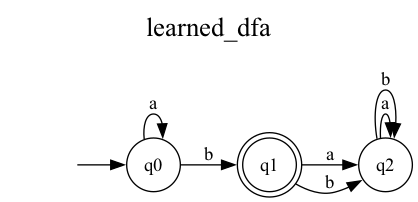


Learned DFA visualized as 'learned_dfa.png'
[DEBUG And.__init__] Initializing And with r1=Star, r2=Char


# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

# Adding State
## State: 1
## Transitions: {}

[DEBUG Star.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5}, final={0}, next_state=6


# Adding State
## State: 1
## Transitions: {}

[DEBUG And.to_nfa] NFA created: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}, next_state=8


### Removing Epsilon Transitions

[DEBUG NFA.remove_epsilon] Initialized new NFA: states={0, 1, 2, 3, 4, 5, 6, 7}, final={7}

[DEBUG NFA.remove_epsilon] Visiting state 0, seen={0}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={0, 2}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={0, 2, 6}
[DEBUG NFA.remove_epsilon] Visiting state 1, seen={1}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={2}
[DEBUG NFA.remove_epsilon] Visiting state 3, seen={3}
[DEBUG NFA.remove_epsilon] Visiting state 0, seen={0, 3}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={0, 2, 3}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={0, 2, 3, 6}
[DEBUG NFA.remove_epsilon] Visiting state 4, seen={4}
[DEBUG NFA.remove_epsilon] Visiting state 5, seen={5}
[DEBUG NFA.remove_epsilon] Visiting state 0, seen={0, 5}
[DEBUG NFA.remove_epsilon] Visiting state 2, seen={0, 2, 5}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={0, 2, 5, 6}
[DEBUG NFA.remove_epsilon] Visiting state 6, seen={6}
[DEBUG NFA.remove_epsilon] Visiting state 7, seen={7}
[DEBUG NFA.remove_epsilon] Marking state 7 as final
[DEBUG NFA.remove_epsilon] Before trimm

[DEBUG NFA.determinise] DFA final states: {3, 5, 6, 7}

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 1
[DEBUG DFA.trim_unreachable] Visited state 1
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Queued state 3
[DEBUG DFA.trim_unreachable] Visited state 3
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Final states: {0, 1, 2, 3}
[DEBUG NFA.determinise] Final DFA: states={0, 1, 2, 3}, transitions={0: {'a': 0, 'b': 0}, 1: {'a': 2, 'b': 3}, 2: {'a': 2, 'b': 3}, 3: {'a': 0, 'b': 0}}
Target DFA visualized as 'target_dfa.png'


Converting Hypothesis to DFA with alphabet: ab

[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2
[DEBUG Transition.target_state] Getting target state for aseq='ba': q2


Transition: q1 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2
[DEBUG Transition.target_state] Getting target state for aseq='bb': q2


Transition: q1 --b--> q2

[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0
[DEBUG Transition.target_state] Getting target state for aseq='a': q0


Transition: q0 --a--> q0

[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1
[DEBUG Transition.target_state] Getting target state for aseq='b': q1


Transition: q0 --b--> q1

[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2
[DEBUG Transition.target_state] Getting target state for aseq='baa': q2


Transition: q2 --a--> q2

[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2
[DEBUG Transition.target_state] Getting target state for aseq='bab': q2


Transition: q2 --b--> q2

[DEBUG DFA.close_with_sink] Adding sink state 4 for alphabet ['a', 'b']


# Adding State
## State: 4
## Transitions: {'a': 4, 'b': 4}

[DEBUG DFA.close_with_sink] Transitions after adding sink: {1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG Hypothesis.to_dfa] DFA after sink: transitions={1: {'a': 2, 'b': 2}, 0: {'a': 0, 'b': 1}, 2: {'a': 2, 'b': 2}, 4: {'a': 4, 'b': 4}}
[DEBUG DFA.is_equivalent] Checking equivalence with another DFA
[DEBUG DFA.complement] Creating complement DFA
[DEBUG DFA.complement] Complement final states: {0, 2, 4}
[DEBUG DFA.intersection] Product states: [(0, 0), (0, 1), (0, 2), (0, 4), (1, 0), (1, 1), (1, 2), (1, 4), (2, 0), (2, 1), (2, 2), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4)]
[DEBUG DFA.intersection] Intersection start state: 4
[DEBUG DFA.intersection] Intersection final states: {12, 14, 15}
[DEBUG DFA.intersection] Transition 0 --a--> 0 (from 0,0)
[DEBUG DFA.intersection] Transition 0 --b--> 1 (from 0,0)
[DEBUG DFA.intersection] Transition 1 --a--> 2 (from 0,1)
[DEBUG DFA.intersection] Transition 1 --b--> 2 (from 0,1)
[DEBUG DFA.intersection] Tra

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 4
[DEBUG DFA.trim_unreachable] Visited state 4
[DEBUG DFA.trim_unreachable] Queued state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 8
[DEBUG DFA.trim_unreachable] Queued state 13
[DEBUG DFA.trim_unreachable] Visited state 13
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Queued state 2
[DEBUG DFA.trim_unreachable] Visited state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 5
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 10
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_un

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Removing unreachable state 1
[DEBUG DFA.trim_unreachable] Removing unreachable state 2
[DEBUG DFA.trim_unreachable] Removing unreachable state 3
[DEBUG DFA.trim_unreachable] Removing unreachable state 4
[DEBUG DFA.trim_unreachable] Removing unreachable state 6
[DEBUG DFA.trim_unreachable] Removing unreachable state 7
[DEBUG DFA.trim_unreachable] Removing unreachable state 8
[DEBUG DFA.trim_unreachable] Removing unreachable state 9
[DEBUG DFA.trim_unreachable] Removing unreachable state 11
[DEBUG DFA.trim_u

### Trimming Unreachable States from DFA

[DEBUG DFA.trim_unreachable] Starting BFS from state 5
[DEBUG DFA.trim_unreachable] Visited state 5
[DEBUG DFA.trim_unreachable] Queued state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 10
[DEBUG DFA.trim_unreachable] Queued state 15
[DEBUG DFA.trim_unreachable] Visited state 15
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Queued state 0
[DEBUG DFA.trim_unreachable] Visited state 0
[DEBUG DFA.trim_unreachable] Final states: {0, 5, 10, 15}
[DEBUG DFA.is_equivalent] After trimming: states={0, 5, 10, 15}
[DEBUG DFA.is_empty] Queuing transition 5 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 5 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 10 --a--> 10
[DEBUG DFA.is_empty] Queuing transition 10 --b--> 15
[DEBUG DFA.is_empty] Queuing transition 15 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 15 --b--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --a--> 0
[DEBUG DFA.is_empty] Queuing transition 0 --b--> 0
[D

### Equivalence Check: Equivalent

In [909]:
if __name__ == "__main__":
    alphabet = "ab"
    # A more complex pattern to induce more learning iterations.
    # This language accepts strings that start with 'a' and end with 'b'.
    pattern = r"(a|b)*b"

    # Check for a command-line argument that is not a flag.
    if len(sys.argv) > 1 and not sys.argv[1].startswith('-'):
        pattern = sys.argv[1]

    __builtins__.print(f"Learning language for regex: '{pattern}' over alphabet '{alphabet}'")

    teacher = PerfectTeacher(alphabet, pattern)
    ttt = TTTAlgorithm(teacher, alphabet)
    hypothesis, dtree = ttt.learn()

    display(Markdown("### Learned Hypothesis"))
    hypothesis.print_hypothesis()
    display(Markdown("### Final Discrimination Tree Visualization"))
    visualize_dtree(dtree)

    visualize_dfa(hypothesis, filename="learned_dfa")
    __builtins__.print("\nLearned DFA visualized as 'learned_dfa.png'")

    target_dfa = Regex.parse(pattern).to_nfa().determinise()
    target_dfa.visualize("target_dfa")
    __builtins__.print("Target DFA visualized as 'target_dfa.png'")

    is_equiv, _ = target_dfa.is_equivalent(hypothesis.to_dfa())
    display(Markdown(f"### Equivalence Check: {'Equivalent' if is_equiv else 'Not Equivalent'}"))


### Conclusion
The TTT algorithm represents a significant advancement in the field of active automata learning, offering a more space- and query-efficient alternative to traditional approaches like Angluin’s L* algorithm. By leveraging discrimination trees and refined counterexample analysis, TTT minimizes redundancy and accelerates the learning process, making it especially effective for inferring the input grammars of blackbox programs.

Through this tutorial, we have explored the theoretical foundations of the TTT algorithm, its practical implementation in Python, and its application to real-world grammar inference tasks. The step-by-step walkthrough, combined with visualizations of the learned automata and discrimination trees, demonstrates how TTT can systematically construct a minimal DFA that accurately models the target language.

As software systems grow in complexity and the need for automated analysis increases, algorithms like TTT will play a crucial role in reverse engineering, protocol inference, and automated testing. By understanding and applying these techniques, practitioners and researchers can gain deeper insights into unknown systems and develop more robust tools for software analysis.

### References

- https://stackoverflow.com/questions/34012886/print-binary-tree-level-by-level-in-python
- Isberner, M., Howar, F., & Steffen, B. (2014). The TTT Algorithm: A Redundancy-Free Approach to Active Automata Learning. Springer, Cham. https://doi.org/10.1007/978-3-319-11164-3_26
- Angluin, D. (1987). Learning Regular Sets from Queries and Counterexamples. Information and Computation, 75(2), 87–106.